Rastrigin synthetic function:

GP EI versus GP dEI (winner)

https://www.sfu.ca/~ssurjano/rastr.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Rastrigin'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Rastrigin':
    
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -5.12
    ub = +5.12

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )
    

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Surrogate derivatives: 

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [9]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [10]:
n_start_AcqFunc = max_iter
inverse = -1


In [11]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

n_start = n_start_AcqFunc

class GPGO_approx(GPGO):
  
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         GP EI: maximum y \t GP EI: exploit'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
  
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def acqfuncApproxMeanTerm(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        gamma = (new_mean - self.tau - eps) / (new_std + eps) 
        
        dm, ds = self.GP.AcqGrad(xnew)
        dsdx = ds / (2 * (new_std + eps))
        dmdx = (dm - gamma * dsdx) / (new_std + eps)
            
        f = (new_std + eps) * (gamma * norm.cdf(gamma))
        df1 = norm.cdf(gamma) * gamma * dsdx
        df2 = (new_std + eps) * (norm.cdf(gamma) * dmdx + norm.pdf(gamma) * gamma)
        df = df1 + df2

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncApprox = -min(self.f_best)
        self.history.append(self.min_acqfuncApprox)

        opt_exploit = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApproxMeanTerm,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        f_best_exploit = np.array([np.atleast_1d(res.fun)[0] for res in opt_exploit])
        self.f_best_exploit = f_best_exploit
        self.min_acqfuncApprox_exploit = -min(self.f_best_exploit)
        self.history.append(self.min_acqfuncApprox_exploit)
        
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncApprox = self.min_acqfuncApprox
        min_acqfuncApprox_exploit = self.min_acqfuncApprox_exploit
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncApprox = BOLD + OKGREEN + str(min_acqfuncApprox) + ENDC
            min_acqfuncApprox_exploit = BOLD + OKGREEN + str(min_acqfuncApprox_exploit) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncApprox, min_acqfuncApprox_exploit))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         GP dEI: maximum y \t GP dEI: exploit'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncExactExploitTerm(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        gamma = (new_mean - self.tau - eps) / (new_std + eps) 
        
        dm, ds = self.GP.AcqGrad(xnew)
        dsdx = ds / (2 * (new_std + eps))
        dmdx = (dm - gamma * dsdx) / (new_std + eps)
            
        f = (new_std + eps) * (gamma * norm.cdf(gamma))
        df1 = norm.cdf(gamma) * gamma * dsdx
        df2 = (new_std + eps) * (norm.cdf(gamma) * dmdx + norm.pdf(gamma) * gamma)
        df = -(df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return -f, np.asarray(df_arr).transpose()

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncExact = -min(self.f_best)
        self.history.append(self.min_acqfuncExact) 
        
        opt_exploit = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExactExploitTerm,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        f_best_exploit = np.array([np.atleast_1d(res.fun)[0] for res in opt_exploit])
        self.f_best_exploit = f_best_exploit
        self.min_acqfuncExact_exploit = -min(self.f_best_exploit)
        self.history.append(self.min_acqfuncExact_exploit)
            
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncExact = self.min_acqfuncExact
        min_acqfuncExact_exploit = self.min_acqfuncExact_exploit
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncExact = BOLD + OKGREEN + str(min_acqfuncExact) + ENDC
            min_acqfuncExact_exploit = BOLD + OKGREEN + str(min_acqfuncExact_exploit) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncExact, min_acqfuncExact_exploit))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-0.84969467  2.25612281]	 20.33436270766351	 19.908403246996286	    	    
init	 [-5.1188288  -2.02411446]	 33.07414982069084	 19.908403246996286	    	    
init	 [-3.61721968 -4.17445279]	 53.347974723929894	 19.908403246996286	    	    
init	 [-3.21269544 -1.58145816]	 39.218472310354045	 19.908403246996286	    	    
init	 [-1.05710106  0.39748336]	 19.908403246996286	 19.908403246996286	    	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 19.908403246996286	 19.908403236996275	 19.908403236996275
2  	 [4.60721335 5.12      ]	 67.96668100470607	 19.908403246996286	 19.90840318387475	 19.90840318387475
3  	 [-5.12  5.12]	 57.849427451571785	 19.908403246996286	 19.908386159773798	 19.908386159773798
4  	 [ 4.13946627 -0.05871948]	 21.41150362481602	 19.908403246996286	 19.908294908352897	 19.908294908352897
5  	 [ 0.90023157 -3.68903381]	 30.05829511815247	 19.908403246996286	 19.9

In [14]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-0.6554122  -4.85451539]	 43.490296251903594	 18.964539418712707	    	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861667536101	 18.964539418712707	    	    
init	 [-0.81543371 -1.73737143]	 20.479562046739524	 18.964539418712707	    	    
init	 [-3.02439799  1.2213347 ]	 18.964539418712707	 18.964539418712707	    	    
init	 [-2.05153614 -2.3876887 ]	 28.041315668371354	 18.964539418712707	    	    
1  	 [2.38617166 4.77152771]	 54.66237788059252	 18.964539418712707	 18.964538255082907	 18.96453822311067
2  	 [ 5.12 -5.12]	 57.849427451571785	 18.964539418712707	 18.964538196136406	 18.964538196136406
3  	 [5.12       0.47381735]	 49.01420306112916	 18.964539418712707	 18.964253317748756	 18.964253317305044
4  	 [-5.12  5.12]	 57.849427451571785	 18.964539418712707	 18.964011927182664	 18.964011927182664
5  	 [-5.12 -5.12]	 57.849427451571785	 18.964539418712707	 18.960823388525

In [15]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [0.52017052 2.1314337 ]	 27.953858411008774	 10.607662635789808	    	    
init	 [-2.14113547  0.11087468]	 10.607662635789808	 10.607662635789808	    	    
init	 [4.02377681 4.05804123]	 33.42749829480097	 10.607662635789808	    	    
init	 [-3.83400642 -2.99783293]	 28.650953928965198	 10.607662635789808	    	    
init	 [-4.59297584 -0.6061072 ]	 57.6631355589384	 10.607662635789808	    	    
1  	 [ 5.12       -3.02919363]	 38.26848757526031	 10.607662635789808	 10.607662645167347	 10.60766202430571
2  	 [-5.12  5.12]	 57.849427451571785	 10.607662635789808	 10.607660548564983	 10.607659927045704
3  	 [ 0.5961628 -5.12     ]	 47.509642946385	 10.607662635789808	 10.607506200434454	 10.60750557866077
4  	 [ 1.61983752 -1.35910867]	 38.09870921315859	 10.607662635789808	 10.566747023861172	 10.566746331263213
5  	 [-1.2386669  5.12     ]	 39.74753161288041	 10.607662635789808	 10

In [16]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [4.78238555 0.48365823]	 51.03163809010808	 14.323038259018315	    	    
init	 [4.84028785 2.19971578]	 39.78645699016559	 14.323038259018315	    	    
init	 [ 2.02474316 -2.90724357]	 14.323038259018315	 14.323038259018315	    	    
init	 [ 4.87705042 -5.05620219]	 52.80627247106233	 14.323038259018315	    	    
init	 [-2.52946061 -0.66773471]	 41.61497868486559	 14.323038259018315	    	    
1  	 [-5.12  5.12]	 57.849427451571785	 14.323038259018315	 14.323038210382029	 14.323038210376208
2  	 [0.36056217 5.12      ]	 45.45613498837177	 14.323038259018315	 14.323018900468911	 14.323018900463113
3  	 [-5.12 -5.12]	 57.849427451571785	 14.323038259018315	 14.323002230148575	 14.323002230142752
4  	 [-0.95955563 -5.12      ]	 30.166610371082413	 14.323038259018315	 14.310508764675394	 14.310508764669242
5	 [0.85384491 1.14528037]	 9.854013339971154	 9.854013339971154	 14.289531617

In [17]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-2.84678993  3.79629882]	 33.93442008827236	 7.8108627039749745	    	    
init	 [-3.00319585  4.2865757 ]	 39.673876075575784	 7.8108627039749745	    	    
init	 [-0.11866943  1.14425716]	 7.8108627039749745	 7.8108627039749745	    	    
init	 [2.72289645 0.1886002 ]	 25.38160395721669	 7.8108627039749745	    	    
init	 [-2.08076286 -3.19773462]	 22.589982116319675	 7.8108627039749745	    	    
1  	 [ 5.12       -4.99232967]	 53.859680359158276	 7.8108627039749745	 7.810883274331691	 7.810494313660058
2  	 [5.12 5.12]	 57.849427451571785	 7.8108627039749745	 7.810880583399053	 7.810491602735789
3  	 [-5.12       -0.04624801]	 29.346087750018796	 7.8108627039749745	 7.80948253948962	 7.809092495206171
4  	 [1.00367549 5.12      ]	 29.934744720429038	 7.8108627039749745	 7.797950818230285	 7.797551899485458
5  	 [-5.12 -5.12]	 57.849427451571785	 7.8108627039749745	 7.7932802472

In [18]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 4.02288795 -1.72052679]	 31.08835710146886	 17.28954482757088	    	    
init	 [ 3.28938622 -4.69302655]	 58.797867722203385	 17.28954482757088	    	    
init	 [-4.0175956   0.97333314]	 17.28954482757088	 17.28954482757088	    	    
init	 [ 0.30532979 -0.83141193]	 19.296253155889353	 17.28954482757088	    	    
init	 [-1.68542362  1.25459899]	 28.650630936276173	 17.28954482757088	    	    
1  	 [5.12 5.12]	 57.849427451571785	 17.28954482757088	 17.28954481698576	 17.28954481698576
2  	 [-4.80259373 -4.71437125]	 64.2654268354374	 17.28954482757088	 17.28954423527899	 17.289544235278896
3  	 [-5.12  5.12]	 57.849427451571785	 17.28954482757088	 17.288698462495336	 17.288698462495336
4  	 [0.39539475 5.12      ]	 46.99777851653171	 17.28954482757088	 17.28821160658744	 17.288211606590213
5  	 [-0.74584822 -5.12      ]	 39.74183768667681	 17.28954482757088	 17.273292610298007	

In [19]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-4.33860312  2.86636843]	 45.646133072936244	 22.52235437888213	    	    
init	 [-0.63068947  2.28828342]	 34.83012662845338	 22.52235437888213	    	    
init	 [4.8946126  0.39419771]	 44.09657005662876	 22.52235437888213	    	    
init	 [ 0.01147355 -4.38219639]	 36.613209822404315	 22.52235437888213	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235437888213	 22.52235437888213	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 22.52235437888213	 22.5223271525891	 22.5223271525891
2  	 [ 5.12 -5.12]	 57.849427451571785	 22.52235437888213	 22.522318976237948	 22.522318976237948
3  	 [3.59561593 5.12      ]	 60.102158804111625	 22.52235437888213	 22.522178732453476	 22.522178732735696
4  	 [-4.02558214 -1.33646422]	 33.289738493146906	 22.52235437888213	 22.52235436888213	 22.52235436888213
5	 [ 1.40596248 -0.96125051]	 21.50030659915684	 21.50030659915684	 22.4661540423

In [20]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [3.82391708 4.79785639]	 50.20079446939181	 13.871821018360485	    	    
init	 [3.78055209 0.31596228]	 36.5114251593508	 13.871821018360485	    	    
init	 [-2.73686192 -5.00327624]	 43.34985765011677	 13.871821018360485	    	    
init	 [-0.7119993  -0.99992207]	 13.871821018360485	 13.871821018360485	    	    
init	 [ 0.23218863 -0.22126801]	 17.190590355445654	 13.871821018360485	    	    
1  	 [-5.12  5.12]	 57.849427451571785	 13.871821018360485	 13.87182100835591	 13.8718196989802
2  	 [ 5.12 -5.12]	 57.849427451571785	 13.871821018360485	 13.871818156847137	 13.871818156818582
3  	 [-5.12       -0.06364033]	 29.71762440781003	 13.871821018360485	 13.871565591201186	 13.871565591013788
4  	 [-0.66932547  4.17628239]	 38.27599827837763	 13.871821018360485	 13.869722654657604	 13.86972265462955
5  	 [ 1.18397079 -4.40958062]	 45.244574900951825	 13.871821018360485	 13.850453

In [21]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-5.01376866  0.01919582]	 25.248289026162446	 24.454800313488693	    	    
init	 [-0.04328148 -3.74958562]	 24.454800313488693	 24.454800313488693	    	    
init	 [-3.66478248 -2.88195916]	 39.46509426509438	 24.454800313488693	    	    
init	 [-0.83447623 -2.57944404]	 31.06766397812992	 24.454800313488693	    	    
init	 [-4.25922917 -1.58209393]	 49.922543556206975	 24.454800313488693	    	    
1  	 [3.51080109 5.12      ]	 61.22741838896637	 24.454800313488693	 24.454800303488692	 24.454800303488692
2  	 [ 5.12       -0.82070126]	 35.300644588387776	 24.454800313488693	 24.454799847060574	 24.454799847060574
3  	 [-2.49910307  5.12      ]	 55.17007107623675	 24.454800313488693	 24.454798878468488	 24.454798878612014
4  	 [ 4.37633724 -5.12      ]	 65.20727067883779	 24.454800313488693	 24.453284877385897	 24.453284877385897
5  	 [0.62646235 1.5424505 ]	 39.42380302867643	 2

In [22]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 2.77832339 -4.90750004]	 41.674330194390116	 13.839458310244165	    	    
init	 [1.36855793 2.54775176]	 44.69639719065837	 13.839458310244165	    	    
init	 [-0.01528819 -2.81808235]	 13.839458310244165	 13.839458310244165	    	    
init	 [-3.09183626  2.66783449]	 33.23221510904937	 13.839458310244165	    	    
init	 [-3.38830503 -4.2154003 ]	 54.73014366983691	 13.839458310244165	    	    
1  	 [ 5.12       -0.56822298]	 48.342836229559616	 13.839458310244165	 13.839194745157116	 13.839194745101318
2  	 [5.12 5.12]	 57.849427451571785	 13.839458310244165	 13.838737394294975	 13.838737394262955
3  	 [-5.12       -0.60617674]	 47.14818198780898	 13.839458310244165	 13.82040158655753	 13.820401586523413
4  	 [-5.12  5.12]	 57.849427451571785	 13.839458310244165	 13.73441165618979	 13.734411656143923
5  	 [-0.83794369  5.12      ]	 34.378128412445356	 13.839458310244165	 13.70

In [23]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-3.27403839 -4.92057353]	 47.655641290890955	 10.679755252484755	    	    
init	 [-0.37664229  2.30332343]	 35.87889240695259	 10.679755252484755	    	    
init	 [-0.81711509 -0.14922651]	 10.679755252484755	 10.679755252484755	    	    
init	 [-4.98912446 -0.12931474]	 28.05462905574235	 10.679755252484755	    	    
init	 [4.52410012 3.59214172]	 71.62694632141611	 10.679755252484755	    	    
1  	 [ 5.12       -4.19757369]	 53.309545194818966	 10.679755252484755	 10.679755258820743	 10.679754745821844
2  	 [-5.12  5.12]	 57.849427451571785	 10.679755252484755	 10.679736422670041	 10.6797359096174
3  	 [ 0.96008613 -5.12      ]	 30.15930307283154	 10.679755252484755	 10.673719223736814	 10.673718702376851
4  	 [ 3.08642864 -0.51789892]	 31.169708360304476	 10.679755252484755	 10.670015725009897	 10.670015198475351
5  	 [1.20979303 5.12      ]	 37.88882045619993	 10.67975525248

In [24]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-3.54137249  2.45810889]	 57.903242869085595	 40.51116653209555	    	    
init	 [-2.42365424  0.34549139]	 40.51116653209555	 40.51116653209555	    	    
init	 [-4.97075238  4.28796936]	 55.62655915398208	 40.51116653209555	    	    
init	 [ 4.10332011 -4.77776458]	 49.962803461970296	 40.51116653209555	    	    
init	 [ 4.6791612  -3.71497655]	 62.183891474990624	 40.51116653209555	    	    
1  	 [5.12 5.12]	 57.849427451571785	 40.51116653209555	 40.51116652209555	 40.51116652209555
2  	 [-5.12 -5.12]	 57.849427451571785	 40.51116653209555	 40.511166354596	 40.511166354596
3	 [2.51251401 0.83277565]	 32.005722529378936	 32.005722529378936	 40.5108964820784	 40.5108964820784
4  	 [0.33246165 5.12      ]	 43.98773777137889	 32.005722529378936	 32.00480783751506	 32.00480783751506
5  	 [-0.48612801 -4.11887937]	 39.82582218172278	 32.005722529378936	 32.00476239107483	 32.004762

In [25]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 2.84367268 -2.68757791]	 33.58019830007169	 17.435826639425656	    	    
init	 [3.32061217 4.76927179]	 56.857057997503354	 17.435826639425656	    	    
init	 [ 4.83943541 -0.47667971]	 48.211919361679726	 17.435826639425656	    	    
init	 [1.11659482 2.82139151]	 17.435826639425656	 17.435826639425656	    	    
init	 [1.45012065 2.27346667]	 38.25352329493884	 17.435826639425656	    	    
1  	 [-5.12       -2.72662604]	 47.82255874469426	 17.435826639425656	 17.435826629425343	 17.435826629425343
2  	 [-5.12  5.12]	 57.849427451571785	 17.435826639425656	 17.435826629045824	 17.435826629045824
3  	 [-1.07700212 -5.12      ]	 31.232396259441025	 17.435826639425656	 17.43504492040659	 17.43504492040659
4	 [-2.85656003  1.1263478 ]	 16.211435218405377	 16.211435218405377	 17.432965983973418	 17.432965983973418
5  	 [-1.15488899  5.12      ]	 34.631880897342306	 16.2114352184053

In [26]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [0.14277984 2.79721013]	 18.683085263052178	 10.423838604848608	    	    
init	 [ 3.7931795  -5.03759925]	 47.36348784446708	 10.423838604848608	    	    
init	 [-1.94830412  4.68586229]	 40.19779334078636	 10.423838604848608	    	    
init	 [ 0.13431513 -1.86076749]	 10.423838604848608	 10.423838604848608	    	    
init	 [ 0.40140736 -2.85434939]	 30.353548735049138	 10.423838604848608	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 10.423838604848608	 10.423838349238634	 10.423837341540427
2  	 [5.12 5.12]	 57.849427451571785	 10.423838604848608	 10.423836054052794	 10.423835046348561
3  	 [-5.12        0.35579134]	 45.21958340622901	 10.423838604848608	 10.423818065791446	 10.423817058002456
4  	 [ 5.12       -0.06379914]	 29.72153355734465	 10.423838604848608	 10.423748909814018	 10.423747901880262
5  	 [-5.12  5.12]	 57.849427451571785	 10.423838604848608	 10.304461634285

In [27]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 3.57189322 -3.28810573]	 54.938487770767075	 7.990765314336182	    	    
init	 [-4.56332069 -1.41784631]	 60.750198753157726	 7.990765314336182	    	    
init	 [-2.29989449  0.3072023 ]	 31.984997246800887	 7.990765314336182	    	    
init	 [-1.9873903  -2.00218256]	 7.990765314336182	 7.990765314336182	    	    
init	 [-3.97576933 -2.5610341 ]	 41.754957769694336	 7.990765314336182	    	    
1  	 [3.22352538 5.12      ]	 47.66004087319409	 7.990765314336182	 7.990779890165227	 7.990507243165965
2  	 [-5.12  5.12]	 57.849427451571785	 7.990765314336182	 7.99077713723363	 7.990504488700184
3  	 [5.12       1.00950206]	 29.961625195999897	 7.990765314336182	 7.989125545259686	 7.988851995737583
4  	 [-0.33203436 -5.12      ]	 43.96411228375585	 7.990765314336182	 7.98321889480877	 7.982942102426407
5  	 [-0.90983276  4.4464838 ]	 41.60134848739645	 7.990765314336182	 7.982677965

In [28]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-2.83349935  0.23719262]	 22.27210456874814	 22.27210456874814	    	    
init	 [ 0.51918292 -4.65303603]	 57.57021076017139	 22.27210456874814	    	    
init	 [-1.42613673 -2.83565116]	 33.89145899403749	 22.27210456874814	    	    
init	 [ 1.9325559  -3.44339021]	 35.85029586225333	 22.27210456874814	    	    
init	 [-4.39987336  4.51595121]	 77.78800881964571	 22.27210456874814	    	    
1  	 [5.12 5.12]	 57.849427451571785	 22.27210456874814	 22.27210455874814	 22.27210455874814
2  	 [5.12       0.13354467]	 32.26111583386254	 22.27210456874814	 22.27182863981133	 22.27182863981133
3  	 [0.5398628  3.56731246]	 51.824017447015066	 22.27210456874814	 22.27159061777961	 22.27159061777961
4  	 [-5.12 -5.12]	 57.849427451571785	 22.27210456874814	 22.270777410706692	 22.270777410706692
5  	 [ 5.12 -5.12]	 57.849427451571785	 22.27210456874814	 22.247836002502357	 22.247836002502

In [29]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-2.10263037  0.31320838]	 20.395145364684023	 20.395145364684023	    	    
init	 [-3.15882714 -4.42470033]	 53.03732051200137	 20.395145364684023	    	    
init	 [2.93873111 1.60085526]	 29.989224812583537	 20.395145364684023	    	    
init	 [1.40821398 0.77417363]	 29.451989415882437	 20.395145364684023	    	    
init	 [-4.71999574 -1.45598869]	 55.89242173757483	 20.395145364684023	    	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 20.395145364684023	 20.39514535410384	 20.39514535410384
2  	 [-5.12        5.04639191]	 54.812614501366646	 20.395145364684023	 20.395143885218694	 20.395143861937797
3  	 [-0.25151688  5.12      ]	 39.08328165022297	 20.395145364684023	 20.394497924888107	 20.394497924888107
4  	 [5.12 5.12]	 57.849427451571785	 20.395145364684023	 20.392568324785124	 20.392568324785124
5  	 [ 1.07732227 -3.51439108]	 34.627838894066734	 20.395145364684023	 20.389

In [30]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [1.53983224 0.05584255]	 22.67190580753611	 22.67190580753611	    	    
init	 [ 3.87687906 -3.25795609]	 38.990099416711985	 22.67190580753611	    	    
init	 [3.60686662 2.56139557]	 56.66448698782129	 22.67190580753611	    	    
init	 [1.70088108 4.99604939]	 40.894059318256296	 22.67190580753611	    	    
init	 [-2.48864335 -4.83014733]	 54.6725749848372	 22.67190580753611	    	    
1  	 [-5.12        2.10205646]	 35.329806981264156	 22.67190580753611	 22.671905797155784	 22.671905797155965
2  	 [-2.46249897  5.12      ]	 54.71229896676769	 22.67190580753611	 22.662989807583642	 22.66298980758363
3  	 [-2.31060743 -0.70591316]	 32.2886926389127	 22.67190580753611	 22.654749728431607	 22.654749728431607
4  	 [ 1.04805566 -5.12      ]	 30.475528403629312	 22.67190580753611	 22.55849899945573	 22.558498999455033
5  	 [-5.12       -2.45342851]	 54.51894691997906	 22.6719058075361

In [31]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 25.867003842388073	 25.867003817800185	 25.867003817800185
2  	 [ 1.77610555 -1.68637021]	 28.257800696860357	 25.867003842388073	 25.863869667308037	 25.863869667378186
3  	 [5.12 5.12]	 57.849427451571785	 25.867003842388073	 25.83968647350202	 25.83968647350202
4  	 [-1.28669658  5.12      ]	 42.865640128605456	 25.867003842388073	 25.830755885472026	 25.830755885472026
5  	 [-5.12       -0.97841466]	 29.973838378434763	 25.867003842388073	 25.8298

In [32]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [0.9024594  4.07258857]	 20.24255447774017	 17.388691338534382	    	    
init	 [4.00927467 3.23417577]	 35.55852254546393	 17.388691338534382	    	    
init	 [-4.75249064  1.96359764]	 36.54582989269194	 17.388691338534382	    	    
init	 [-1.24230715  0.18955208]	 17.388691338534382	 17.388691338534382	    	    
init	 [ 1.61742301 -3.13497377]	 33.22932870179905	 17.388691338534382	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.388691338534382	 17.388691324429224	 17.388691324429224
2  	 [ 5.12       -0.92646264]	 30.831636408205867	 17.388691338534382	 17.38387969925886	 17.38387969925886
3  	 [ 5.12 -5.12]	 57.849427451571785	 17.388691338534382	 17.381329812260716	 17.381329812260716
4  	 [-2.70368996  5.12      ]	 49.10351295059661	 17.388691338534382	 17.364569480344798	 17.36456948034485
5  	 [-1.34011193 -5.12      ]	 46.0848184885253	 17.388691338534382	 17.336645

In [33]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-0.84969467  2.25612281]	 20.33436270766351	 19.908403246996286	    	    
init	 [-5.1188288  -2.02411446]	 33.07414982069084	 19.908403246996286	    	    
init	 [-3.61721968 -4.17445279]	 53.347974723929894	 19.908403246996286	    	    
init	 [-3.21269544 -1.58145816]	 39.218472310354045	 19.908403246996286	    	    
init	 [-1.05710106  0.39748336]	 19.908403246996286	 19.908403246996286	    	    
1  	 [ 4.04077223 -4.24914728]	 44.655863836006326	 19.908403246996286	 19.908403236569633	 19.908403236569633
2  	 [5.12 5.12]	 57.849427451571785	 19.908403246996286	 19.90840323415899	 19.90840323415899
3  	 [4.33744349 0.432798  ]	 53.344410128242544	 19.908403246996286	 19.90766397882616	 19.907663978826147
4  	 [-5.12        4.36680096]	 64.69123843795754	 19.908403246996286	 19.90829130925116	 19.90829130925116
5  	 [ 0.15769158 -5.09614947]	 32.285447952253	 19.9084032469962

In [34]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-0.6554122  -4.85451539]	 43.490296251903594	 18.964539418712707	    	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861667536101	 18.964539418712707	    	    
init	 [-0.81543371 -1.73737143]	 20.479562046739524	 18.964539418712707	    	    
init	 [-3.02439799  1.2213347 ]	 18.964539418712707	 18.964539418712707	    	    
init	 [-2.05153614 -2.3876887 ]	 28.041315668371354	 18.964539418712707	    	    
1  	 [5.12       3.79058262]	 50.77089119709249	 18.964539418712707	 18.96453938815674	 18.96453938815674
2  	 [ 4.8426374  -3.96513962]	 43.91494982240336	 18.964539418712707	 18.9645292393409	 18.9645292393409
3  	 [0.07192172 5.12      ]	 29.933685188852706	 18.964539418712707	 18.964468578788942	 18.964468578788942
4  	 [-5.12 -5.12]	 57.849427451571785	 18.964539418712707	 18.96082338803084	 18.96082338803084
5  	 [ 4.59349575 -0.07218847]	 40.44010539027009	 18.96453941871270

In [35]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [0.52017052 2.1314337 ]	 27.953858411008774	 10.607662635789808	    	    
init	 [-2.14113547  0.11087468]	 10.607662635789808	 10.607662635789808	    	    
init	 [4.02377681 4.05804123]	 33.42749829480097	 10.607662635789808	    	    
init	 [-3.83400642 -2.99783293]	 28.650953928965198	 10.607662635789808	    	    
init	 [-4.59297584 -0.6061072 ]	 57.6631355589384	 10.607662635789808	    	    
1  	 [ 1.67759318 -3.17566744]	 32.79081619438729	 10.607662635789808	 10.607639236553297	 10.607638650749266
2  	 [-3.55868405  4.82551581]	 60.708961282145246	 10.607662635789808	 10.607539928681135	 10.607539309295317
3  	 [ 5.12      -0.3507253]	 44.96238197718422	 10.607662635789808	 10.60628490665781	 10.606284274210797
4  	 [-1.57258335 -5.10192032]	 49.46191739291357	 10.607662635789808	 10.478411578989444	 10.478410209441535
5  	 [ 4.60130562 -3.45104534]	 70.65406330267014	 10.

In [36]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [4.78238555 0.48365823]	 51.03163809010808	 14.323038259018315	    	    
init	 [4.84028785 2.19971578]	 39.78645699016559	 14.323038259018315	    	    
init	 [ 2.02474316 -2.90724357]	 14.323038259018315	 14.323038259018315	    	    
init	 [ 4.87705042 -5.05620219]	 52.80627247106233	 14.323038259018315	    	    
init	 [-2.52946061 -0.66773471]	 41.61497868486559	 14.323038259018315	    	    
1  	 [-2.37593926  5.12      ]	 51.682475782417484	 14.323038259018315	 14.323037154731137	 14.323037154725636
2  	 [-5.12 -5.12]	 57.849427451571785	 14.323038259018315	 14.323002230149687	 14.323002230143864
3  	 [1.96075502 5.12      ]	 33.07175374525896	 14.323038259018315	 14.317069408044068	 14.317069408035856
4  	 [0.79127659 1.31343849]	 23.667976570604065	 14.323038259018315	 14.295724376544108	 14.310322777390448
5  	 [-1.08833013 -4.87479297]	 29.387172349591154	 14.32303825901

In [37]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-2.84678993  3.79629882]	 33.93442008827236	 7.8108627039749745	    	    
init	 [-3.00319585  4.2865757 ]	 39.673876075575784	 7.8108627039749745	    	    
init	 [-0.11866943  1.14425716]	 7.8108627039749745	 7.8108627039749745	    	    
init	 [2.72289645 0.1886002 ]	 25.38160395721669	 7.8108627039749745	    	    
init	 [-2.08076286 -3.19773462]	 22.589982116319675	 7.8108627039749745	    	    
1  	 [ 4.32894502 -5.09733749]	 61.29459456639687	 7.8108627039749745	 7.810881347216296	 7.810492367012083
2  	 [5.12 5.12]	 57.849427451571785	 7.8108627039749745	 7.810880583399788	 7.810491602736525
3  	 [-5.12       -0.31192635]	 42.81552120921353	 7.8108627039749745	 7.8089377374162465	 7.80869375618108
4  	 [1.11276445 4.76007737]	 35.670566143430165	 7.8108627039749745	 7.793938181882096	 7.793135038640674
5  	 [-5.12 -5.12]	 57.849427451571785	 7.8108627039749745	 7.793115264

In [38]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 4.02288795 -1.72052679]	 31.08835710146886	 17.28954482757088	    	    
init	 [ 3.28938622 -4.69302655]	 58.797867722203385	 17.28954482757088	    	    
init	 [-4.0175956   0.97333314]	 17.28954482757088	 17.28954482757088	    	    
init	 [ 0.30532979 -0.83141193]	 19.296253155889353	 17.28954482757088	    	    
init	 [-1.68542362  1.25459899]	 28.650630936276173	 17.28954482757088	    	    
1  	 [5.12 5.12]	 57.849427451571785	 17.28954482757088	 17.28954481698576	 17.28954481698576
2  	 [-5.12 -5.12]	 57.849427451571785	 17.28954482757088	 17.289544778430603	 17.289544778430603
3  	 [0.39239961 5.12      ]	 46.879049981380305	 17.28954482757088	 17.288218848126796	 17.288218848126796
4  	 [-0.95408494 -4.92186911]	 26.729297813340416	 17.28954482757088	 17.280194724131146	 17.280194724131146
5  	 [3.88132283 1.66847213]	 35.40357333585098	 17.28954482757088	 17.20503138168

In [39]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-4.33860312  2.86636843]	 45.646133072936244	 22.52235437888213	    	    
init	 [-0.63068947  2.28828342]	 34.83012662845338	 22.52235437888213	    	    
init	 [4.8946126  0.39419771]	 44.09657005662876	 22.52235437888213	    	    
init	 [ 0.01147355 -4.38219639]	 36.613209822404315	 22.52235437888213	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235437888213	 22.52235437888213	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 22.52235437888213	 22.5223271525891	 22.5223271525891
2  	 [3.66237484 5.12      ]	 57.569392297613234	 22.52235437888213	 22.522177196868483	 22.522177195655278
3  	 [ 4.52828409 -4.16265128]	 62.45864721017638	 22.52235437888213	 22.5210520808623	 22.5210520808623
4  	 [-4.02558214 -1.33646422]	 33.289738493146906	 22.52235437888213	 22.52235436888213	 22.52235436888213
5	 [ 1.30561129 -0.85934528]	 19.524098049117512	 19.524098049117512	 22

In [40]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [3.82391708 4.79785639]	 50.20079446939181	 13.871821018360485	    	    
init	 [3.78055209 0.31596228]	 36.5114251593508	 13.871821018360485	    	    
init	 [-2.73686192 -5.00327624]	 43.34985765011677	 13.871821018360485	    	    
init	 [-0.7119993  -0.99992207]	 13.871821018360485	 13.871821018360485	    	    
init	 [ 0.23218863 -0.22126801]	 17.190590355445654	 13.871821018360485	    	    
1  	 [ 4.96376909 -4.82584897]	 53.598448729164815	 13.871821018360485	 13.871804552259617	 13.87180455223105
2  	 [-5.03492225  2.95509263]	 34.71822332027364	 13.871821018360485	 13.871820781110607	 13.871820781082052
3  	 [-0.88346227  5.12      ]	 32.26835247215	 13.871821018360485	 13.871149387167755	 13.871149387117194
4  	 [ 1.0844111  -4.79070896]	 32.97062299379361	 13.871821018360485	 13.842134558934491	 13.842134558902844
5  	 [-5.12       -1.44673329]	 50.46289040957707	 13.87

In [41]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-5.01376866  0.01919582]	 25.248289026162446	 24.454800313488693	    	    
init	 [-0.04328148 -3.74958562]	 24.454800313488693	 24.454800313488693	    	    
init	 [-3.66478248 -2.88195916]	 39.46509426509438	 24.454800313488693	    	    
init	 [-0.83447623 -2.57944404]	 31.06766397812992	 24.454800313488693	    	    
init	 [-4.25922917 -1.58209393]	 49.922543556206975	 24.454800313488693	    	    
1  	 [5.12 5.12]	 57.849427451571785	 24.454800313488693	 24.454800303488692	 24.454800303488692
2  	 [ 5.03785231 -1.04596176]	 27.16958169742484	 24.454800313488693	 24.454799385147297	 24.454799385147297
3  	 [-1.47691444  4.45110873]	 61.42049213265991	 24.454800313488693	 24.45479920624852	 24.45479920624852
4  	 [1.55244529 1.27551439]	 35.09524858557889	 24.454800313488693	 24.45016399153349	 24.45016399153349
5  	 [-2.25090749  1.29293161]	 29.460154598682422	 24.45480031348

In [42]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 2.77832339 -4.90750004]	 41.674330194390116	 13.839458310244165	    	    
init	 [1.36855793 2.54775176]	 44.69639719065837	 13.839458310244165	    	    
init	 [-0.01528819 -2.81808235]	 13.839458310244165	 13.839458310244165	    	    
init	 [-3.09183626  2.66783449]	 33.23221510904937	 13.839458310244165	    	    
init	 [-3.38830503 -4.2154003 ]	 54.73014366983691	 13.839458310244165	    	    
1  	 [ 5.12       -0.53830217]	 48.92629267922258	 13.839458310244165	 13.839193299462396	 13.839193299422716
2  	 [5.12 5.12]	 57.849427451571785	 13.839458310244165	 13.838736940818274	 13.838736940786253
3  	 [-4.22754093 -0.73798976]	 37.76417471725897	 13.839458310244165	 13.767410946664924	 13.767410946623968
4  	 [ 1.77944761 -0.72160778]	 23.6219314007071	 13.839458310244165	 13.495993287041971	 13.495993286848535
5  	 [-4.5050859   5.00650982]	 65.36419794062027	 13.8394583102

In [43]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-3.27403839 -4.92057353]	 47.655641290890955	 10.679755252484755	    	    
init	 [-0.37664229  2.30332343]	 35.87889240695259	 10.679755252484755	    	    
init	 [-0.81711509 -0.14922651]	 10.679755252484755	 10.679755252484755	    	    
init	 [-4.98912446 -0.12931474]	 28.05462905574235	 10.679755252484755	    	    
init	 [4.52410012 3.59214172]	 71.62694632141611	 10.679755252484755	    	    
1  	 [ 3.03550212 -4.46785095]	 49.22040431745476	 10.679755252484755	 10.67975494666741	 10.679754433640142
2  	 [ 4.25360926 -0.55294285]	 48.0774987666756	 10.679755252484755	 10.667816115686156	 10.667815499765732
3  	 [1.24702516 5.12      ]	 40.292881856182845	 10.679755252484755	 10.537519173805586	 10.537773779335167
4  	 [-0.14982725 -3.281103  ]	 26.843298318720986	 10.679755252484755	 10.52699427880254	 10.52699350979042
5  	 [-3.6313084   3.02560873]	 39.25519344676327	 10.

In [44]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-3.54137249  2.45810889]	 57.903242869085595	 40.51116653209555	    	    
init	 [-2.42365424  0.34549139]	 40.51116653209555	 40.51116653209555	    	    
init	 [-4.97075238  4.28796936]	 55.62655915398208	 40.51116653209555	    	    
init	 [ 4.10332011 -4.77776458]	 49.962803461970296	 40.51116653209555	    	    
init	 [ 4.6791612  -3.71497655]	 62.183891474990624	 40.51116653209555	    	    
1  	 [5.12 5.12]	 57.849427451571785	 40.51116653209555	 40.51116652209555	 40.51116652209555
2  	 [-5.12 -5.12]	 57.849427451571785	 40.51116653209555	 40.511166354596	 40.511166354596
3	 [2.39120481 0.97307722]	 24.5606403651218	 24.5606403651218	 40.51085659049695	 40.51085659049695
4  	 [-0.46882411 -4.42580423]	 58.54919150500953	 24.5606403651218	 24.55961089021675	 24.55961089021675
5  	 [0.89124597 4.54092672]	 43.33072399829906	 24.5606403651218	 24.5503937109417	 24.55024286292

In [45]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 2.84367268 -2.68757791]	 33.58019830007169	 17.435826639425656	    	    
init	 [3.32061217 4.76927179]	 56.857057997503354	 17.435826639425656	    	    
init	 [ 4.83943541 -0.47667971]	 48.211919361679726	 17.435826639425656	    	    
init	 [1.11659482 2.82139151]	 17.435826639425656	 17.435826639425656	    	    
init	 [1.45012065 2.27346667]	 38.25352329493884	 17.435826639425656	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.435826639425656	 17.43582662942564	 17.43582662942564
2  	 [-3.81749683  0.42652771]	 39.59347826031612	 17.435826639425656	 17.435820572853327	 17.435820572853327
3  	 [-2.89939236  5.12      ]	 39.26351982732489	 17.435826639425656	 17.43556617907401	 17.43556617907401
4  	 [-0.69420447 -5.12      ]	 42.84099984901968	 17.435826639425656	 17.43255839935984	 17.43255839935984
5  	 [-2.78914898 -2.47302964]	 41.316915597905414	 17.435826639425656

In [46]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [0.14277984 2.79721013]	 18.683085263052178	 10.423838604848608	    	    
init	 [ 3.7931795  -5.03759925]	 47.36348784446708	 10.423838604848608	    	    
init	 [-1.94830412  4.68586229]	 40.19779334078636	 10.423838604848608	    	    
init	 [ 0.13431513 -1.86076749]	 10.423838604848608	 10.423838604848608	    	    
init	 [ 0.40140736 -2.85434939]	 30.353548735049138	 10.423838604848608	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 10.423838604848608	 10.423838349238634	 10.423837341540427
2  	 [5.12 5.12]	 57.849427451571785	 10.423838604848608	 10.423836054052794	 10.423835046348561
3  	 [-5.12       0.3554545]	 45.20267174597589	 10.423838604848608	 10.423818065806698	 10.423816810164372
4  	 [ 5.12       -0.06050559]	 29.64235096159109	 10.423838604848608	 10.423748898324018	 10.423747901872453
5  	 [-1.59760721 -0.03747418]	 21.007297417913293	 10.423838604848608	 10.

In [47]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 3.57189322 -3.28810573]	 54.938487770767075	 7.990765314336182	    	    
init	 [-4.56332069 -1.41784631]	 60.750198753157726	 7.990765314336182	    	    
init	 [-2.29989449  0.3072023 ]	 31.984997246800887	 7.990765314336182	    	    
init	 [-1.9873903  -2.00218256]	 7.990765314336182	 7.990765314336182	    	    
init	 [-3.97576933 -2.5610341 ]	 41.754957769694336	 7.990765314336182	    	    
1  	 [5.12 5.12]	 57.849427451571785	 7.990765314336182	 7.990779890199916	 7.990507243165966
2  	 [-0.35157246  5.12      ]	 45.005812766692976	 7.990765314336182	 7.990748857348481	 7.99047478793911
3  	 [2.59308841 1.16950306]	 31.584688947189136	 7.990765314336182	 7.989281592406023	 7.989008128013564
4  	 [-5.04628403  4.05419228]	 42.89546382913226	 7.990765314336182	 7.990241474878395	 7.9899678091435575
5  	 [-1.61688397 -5.12      ]	 48.96133288911423	 7.990765314336182	 7.9398

In [48]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-2.83349935  0.23719262]	 22.27210456874814	 22.27210456874814	    	    
init	 [ 0.51918292 -4.65303603]	 57.57021076017139	 22.27210456874814	    	    
init	 [-1.42613673 -2.83565116]	 33.89145899403749	 22.27210456874814	    	    
init	 [ 1.9325559  -3.44339021]	 35.85029586225333	 22.27210456874814	    	    
init	 [-4.39987336  4.51595121]	 77.78800881964571	 22.27210456874814	    	    
1  	 [5.12 5.12]	 57.849427451571785	 22.27210456874814	 22.27210455874814	 22.27210455874814
2  	 [5.12     0.135655]	 32.36092416035443	 22.27210456874814	 22.271828627969274	 22.271828627969274
3  	 [0.43755248 3.98750253]	 35.362499449628345	 22.27210456874814	 22.271513294204595	 22.271513294204595
4  	 [-5.12 -5.12]	 57.849427451571785	 22.27210456874814	 22.270777410718544	 22.270777410718544
5  	 [0.82489184 0.43273641]	 25.45399405097639	 22.27210456874814	 22.216551594464626	 22.2

In [49]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-2.10263037  0.31320838]	 20.395145364684023	 20.395145364684023	    	    
init	 [-3.15882714 -4.42470033]	 53.03732051200137	 20.395145364684023	    	    
init	 [2.93873111 1.60085526]	 29.989224812583537	 20.395145364684023	    	    
init	 [1.40821398 0.77417363]	 29.451989415882437	 20.395145364684023	    	    
init	 [-4.71999574 -1.45598869]	 55.89242173757483	 20.395145364684023	    	    
1  	 [ 4.96008736 -4.44720822]	 64.14783177084814	 20.395145364684023	 20.395145305707423	 20.395145305707423
2  	 [-1.51638461  5.12      ]	 51.17119182678712	 20.395145364684023	 20.39504778016532	 20.39504778016532
3  	 [5.12 5.12]	 57.849427451571785	 20.395145364684023	 20.392578904491298	 20.392578904491298
4  	 [ 0.84045277 -5.12      ]	 34.24880863486494	 20.395145364684023	 20.382873056610034	 20.378840434437198
5  	 [ 5.12       -0.71699151]	 41.49793838029413	 20.395145364684

In [50]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [1.53983224 0.05584255]	 22.67190580753611	 22.67190580753611	    	    
init	 [ 3.87687906 -3.25795609]	 38.990099416711985	 22.67190580753611	    	    
init	 [3.60686662 2.56139557]	 56.66448698782129	 22.67190580753611	    	    
init	 [1.70088108 4.99604939]	 40.894059318256296	 22.67190580753611	    	    
init	 [-2.48864335 -4.83014733]	 54.6725749848372	 22.67190580753611	    	    
1  	 [-5.00718904  2.9174042 ]	 34.91005808676357	 22.67190580753611	 22.671905797046726	 22.671905797046726
2  	 [-2.5172874  -0.57162906]	 45.60877814255882	 22.67190580753611	 22.66450117022293	 22.66450117022293
3	 [-1.16270398  2.84418166]	 18.64896345126307	 18.64896345126307	 22.594935781672323	 22.594936284603886
4  	 [ 0.94316799 -5.09984298]	 29.43280579581087	 18.64896345126307	 18.52757528971427	 18.527575032457204
5  	 [-5.12       -3.24013922]	 48.80404132120228	 18.64896345126307	

In [51]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 4.82659077 -3.73107955]	 53.77420826130772	 25.867003842388073	 25.866958859664855	 25.866958859664855
2	 [-0.85223298  0.10979632]	 7.034295421249853	 7.034295421249853	 25.855043552960773	 25.855043552960773
3  	 [5.12 5.12]	 57.849427451571785	 7.034295421249853	 7.007093301406828	 7.0053691333582355
4  	 [-5.11255451 -1.1055489 ]	 31.87825221324293	 7.034295421249853	 6.993867956507509	 6.991799045368637
5  	 [ 1.56245442 -1.92118448]	 26.573427226374246	 7.034295421249853	 6.9

In [52]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [0.9024594  4.07258857]	 20.24255447774017	 17.388691338534382	    	    
init	 [4.00927467 3.23417577]	 35.55852254546393	 17.388691338534382	    	    
init	 [-4.75249064  1.96359764]	 36.54582989269194	 17.388691338534382	    	    
init	 [-1.24230715  0.18955208]	 17.388691338534382	 17.388691338534382	    	    
init	 [ 1.61742301 -3.13497377]	 33.22932870179905	 17.388691338534382	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.388691338534382	 17.388691324429224	 17.388691324429224
2  	 [ 5.12       -0.90774061]	 31.382342682975256	 17.388691338534382	 17.383872698790483	 17.383872698790483
3  	 [-2.32334252  4.6958363 ]	 55.23356041730585	 17.388691338534382	 17.320008093204432	 17.320008093204432
4  	 [-1.42211353 -5.12      ]	 49.77338827837845	 17.388691338534382	 17.33480809013927	 17.33480809013934
5  	 [-5.12       -1.50067346]	 51.17664504423531	 17.38869133853

In [53]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)]) 
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(2.560333718691756, 2.9911419163163977)

In [54]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)]) 
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(2.788744399428772, 2.9425708889884663)

In [55]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)]) 
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(2.361576630127625, 2.361576630127625)

In [56]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)]) 
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(2.287878817882896, 2.6488079738442334)

In [57]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)]) 
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(2.05551541920764, 1.8954626597772544)

In [58]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)]) 
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(2.305694781048611, 2.0031187980196936)

In [59]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)]) 
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(2.651841186807373, 2.9716494999912664)

In [60]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)]) 
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(2.6298595175876263, 2.1925571922207507)

In [61]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)]) 
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(2.82849388564378, 2.226896329775584)

In [62]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)]) 
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(2.5241871392458695, 1.1954175839502463)

In [63]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)]) 
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(2.3683499168354514, 2.3683499168354514)

In [64]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)]) 
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(2.168116454057699, 3.133243352216147)

In [65]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)]) 
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(2.763738150093859, 1.7819371952409373)

In [66]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)]) 
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(2.3440953566682032, 2.3440953566682032)

In [67]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)]) 
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(2.078286539213237, 2.078286539213237)

In [68]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)]) 
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(0.7564268872117674, 1.8668773589138925)

In [69]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)]) 
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(2.3974009932661375, 1.9582744638521108)

In [70]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)]) 
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(2.7045923174018656, 2.6976772806421248)

In [71]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)]) 
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(2.9282445915304662, 1.95079753221021)

In [72]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)]) 
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(2.8558200718561926, 1.8555330690381389)

In [73]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [74]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [75]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [76]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [77]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [78]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [79]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [80]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [81]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [82]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [83]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [84]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [85]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [86]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [87]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [88]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [89]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [90]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [91]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [92]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [93]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [94]:
### Summarise arrays: 'GP EI'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [95]:
### Summarise arrays: 'GP dEI'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [96]:
def extractAcqFuncMax(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-3]
    return new_array

def exploitExtract(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-3]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-3] * -1
    return new_array


In [97]:
approx1_acqFuncMax = extractAcqFuncMax(approx_1.history) + eps
approx1_exploit = exploitExtract(approx_1.history) + eps
approx1_ratio = approx1_exploit/approx1_acqFuncMax 

np.round(approx1_acqFuncMax, 3), np.round(approx1_exploit,3)


(array([19.908, 19.908, 19.908, 19.908, 19.905, 19.845, 19.811, 19.566,
        19.189, 19.165, 18.845, 18.718, 18.485, 17.488, 17.107,  9.912,
         8.291,  7.514,  6.742,  6.577]),
 array([19.908, 19.908, 19.908, 19.908, 19.905, 19.845, 19.811, 19.566,
        19.189, 19.165, 18.845, 18.718, 18.485, 17.488, 17.107,  9.912,
         8.291,  7.513,  6.739,  6.573]))

In [98]:
approx2_acqFuncMax = extractAcqFuncMax(approx_2.history) + eps
approx2_exploit = exploitExtract(approx_2.history) + eps
approx2_ratio = approx2_exploit/approx2_acqFuncMax

np.round(approx2_acqFuncMax, 3), np.round(approx2_exploit, 3)


(array([18.965, 18.965, 18.964, 18.964, 18.961, 18.916, 18.838, 18.691,
        18.482, 18.352, 17.876, 17.789, 17.641, 15.919, 15.482, 14.85 ,
        14.701, 14.7  , 13.855,  9.909]),
 array([18.965, 18.965, 18.964, 18.964, 18.961, 18.916, 18.838, 18.691,
        18.482, 18.352, 17.876, 17.789, 17.641, 15.919, 15.482, 14.85 ,
        14.701, 14.7  , 13.855,  9.909]))

In [99]:
approx3_acqFuncMax = extractAcqFuncMax(approx_3.history) + eps
approx3_exploit = exploitExtract(approx_3.history) + eps
approx3_ratio = approx3_exploit/approx3_acqFuncMax

np.round(approx3_acqFuncMax, 3), np.round(approx3_exploit, 3)


(array([10.608, 10.608, 10.608, 10.567, 10.558, 10.552, 10.111,  9.976,
         9.815,  9.678,  9.664,  9.164,  8.264,  7.299,  6.668,  5.5  ,
         4.426,  4.762,  4.053,  3.492]),
 array([10.608, 10.608, 10.608, 10.567, 10.558, 10.552, 10.111,  9.976,
         9.815,  9.678,  9.664,  8.264,  8.264,  7.298,  5.484,  5.484,
         3.954,  4.716,  3.953,  2.961]))

In [100]:
approx4_acqFuncMax = extractAcqFuncMax(approx_4.history) + eps
approx4_exploit = exploitExtract(approx_4.history) + eps
approx4_ratio = approx4_exploit/approx4_acqFuncMax

np.round(approx4_acqFuncMax, 3), np.round(approx4_exploit, 3)


(array([14.323, 14.323, 14.323, 14.311, 14.29 ,  9.743,  9.655,  9.595,
         8.885,  9.281,  8.778,  8.726,  8.321,  8.08 ,  7.954,  7.135,
         6.963,  4.571,  3.428,  2.762]),
 array([14.323, 14.323, 14.323, 14.311, 14.29 ,  9.743,  9.655,  9.595,
         8.885,  9.281,  8.778,  8.726,  8.321,  8.08 ,  7.953,  7.134,
         6.961,  4.514,  1.126,  1.518]))

In [101]:
approx5_acqFuncMax = extractAcqFuncMax(approx_5.history) + eps
approx5_exploit = exploitExtract(approx_5.history) + eps
approx5_ratio = approx5_exploit/approx5_acqFuncMax

np.round(approx5_acqFuncMax, 3), np.round(approx5_exploit, 3)


(array([7.811, 7.811, 7.809, 7.798, 7.793, 7.791, 7.581, 7.42 , 7.426,
        7.264, 6.71 , 6.596, 6.119, 5.904, 5.79 , 5.696, 4.375, 3.608,
        5.25 , 4.15 ]),
 array([7.81 , 7.81 , 7.809, 7.798, 7.793, 7.791, 7.581, 7.419, 7.426,
        7.262, 6.707, 6.592, 6.111, 5.893, 5.778, 5.683, 4.323, 3.461,
        4.07 , 4.07 ]))

In [102]:
approx6_acqFuncMax = extractAcqFuncMax(approx_6.history) + eps
approx6_exploit = exploitExtract(approx_6.history) + eps
approx6_ratio = approx6_exploit/approx6_acqFuncMax

np.round(approx6_acqFuncMax, 3), np.round(approx6_exploit, 3)


(array([17.29 , 17.29 , 17.289, 17.288, 17.273, 17.25 , 17.042, 16.648,
        16.389, 16.362, 15.539,  8.277,  7.653,  7.158,  6.905,  5.861,
         5.001,  4.95 ,  4.019,  3.62 ]),
 array([17.29 , 17.29 , 17.289, 17.288, 17.273, 17.25 , 17.042, 16.648,
        16.389, 16.362, 15.539,  8.277,  7.652,  7.157,  6.903,  5.851,
         4.967,  4.925,  3.914,  3.825]))

In [103]:
approx7_acqFuncMax = extractAcqFuncMax(approx_7.history) + eps
approx7_exploit = exploitExtract(approx_7.history) + eps
approx7_ratio = approx7_exploit/approx7_acqFuncMax

np.round(approx7_acqFuncMax, 3), np.round(approx7_exploit, 3)


(array([22.522, 22.522, 22.522, 22.522, 22.466, 21.27 , 20.892, 20.763,
        20.228, 20.096, 20.097, 19.598, 19.518, 18.894, 18.745, 15.706,
        16.042, 14.36 , 14.17 ,  6.391]),
 array([22.522, 22.522, 22.522, 22.522, 22.466, 21.27 , 20.892, 20.763,
        20.228, 20.096, 20.097, 19.598, 19.518, 18.894, 18.745, 15.706,
        16.042, 14.173, 14.17 ,  6.386]))

In [104]:
approx8_acqFuncMax = extractAcqFuncMax(approx_8.history) + eps
approx8_exploit = exploitExtract(approx_8.history) + eps
approx8_ratio = approx8_exploit/approx8_acqFuncMax

np.round(approx8_acqFuncMax, 3), np.round(approx8_exploit, 3)


(array([13.872, 13.872, 13.872, 13.87 , 13.85 , 13.555, 13.17 , 13.519,
        13.17 , 12.539, 12.389, 12.326, 11.769, 10.793, 10.797, 10.022,
         9.772,  8.724,  8.574,  7.983]),
 array([13.872, 13.872, 13.872, 13.87 , 13.85 , 13.555, 13.17 , 13.519,
        13.17 , 12.539, 12.389, 12.326, 11.769, 10.793, 10.797, 10.022,
         9.772,  8.724,  8.574,  7.982]))

In [105]:
approx9_acqFuncMax = extractAcqFuncMax(approx_9.history) + eps
approx9_exploit = exploitExtract(approx_9.history) + eps
approx9_ratio = approx9_exploit/approx9_acqFuncMax

np.round(approx9_acqFuncMax, 3), np.round(approx9_exploit, 3)


(array([24.455, 24.455, 24.455, 24.453, 24.453, 24.25 , 24.161, 24.064,
        23.979, 23.939, 23.787, 23.091, 21.041, 22.759, 20.834, 20.603,
        19.036, 12.739, 11.092,  9.128]),
 array([24.455, 24.455, 24.455, 24.453, 24.453, 24.25 , 24.161, 24.064,
        23.979, 23.939, 23.787, 23.091, 21.041, 22.759, 20.834, 20.603,
        19.036, 12.739, 11.092,  9.128]))

In [106]:
approx10_acqFuncMax = extractAcqFuncMax(approx_10.history) + eps
approx10_exploit = exploitExtract(approx_10.history) + eps
approx10_ratio = approx10_exploit/approx10_acqFuncMax

np.round(approx10_acqFuncMax, 3), np.round(approx10_exploit, 3)


(array([13.839, 13.839, 13.82 , 13.734, 13.7  , 13.66 , 12.096, 11.697,
        11.557, 11.669, 11.311, 10.393,  9.792,  9.53 ,  9.3  ,  8.77 ,
         8.069,  7.972,  7.304,  6.64 ]),
 array([13.839, 13.839, 13.82 , 13.734, 13.7  , 13.66 , 12.096, 11.697,
        11.557, 11.669, 11.311, 10.393,  9.3  ,  9.53 ,  9.3  ,  8.77 ,
         8.069,  7.972,  7.303,  6.853]))

In [107]:
approx11_acqFuncMax = extractAcqFuncMax(approx_11.history) + eps
approx11_exploit = exploitExtract(approx_11.history) + eps
approx11_ratio = approx11_exploit/approx11_acqFuncMax

np.round(approx11_acqFuncMax, 3), np.round(approx11_exploit, 3)


(array([10.68 , 10.68 , 10.674, 10.67 , 10.538, 10.264, 10.229, 10.06 ,
         9.834,  9.288,  9.234,  8.803,  8.497,  7.77 ,  7.213,  6.369,
         6.327,  5.083,  4.441,  4.347]),
 array([10.68 , 10.68 , 10.674, 10.67 , 10.538, 10.264, 10.229, 10.06 ,
         9.834,  9.288,  9.234,  8.497,  8.497,  7.77 ,  7.212,  6.364,
         6.322,  4.284,  4.389,  4.289]))

In [108]:
approx12_acqFuncMax = extractAcqFuncMax(approx_12.history) + eps
approx12_exploit = exploitExtract(approx_12.history) + eps
approx12_ratio = approx12_exploit/approx12_acqFuncMax

np.round(approx12_acqFuncMax, 3), np.round(approx12_exploit, 3)


(array([40.511, 40.511, 40.511, 32.005, 32.005, 31.869, 31.656, 31.497,
        22.349,  7.489,  7.172,  7.152,  6.718,  6.609,  6.493,  5.17 ,
         4.322,  3.25 ,  4.653,  3.505]),
 array([40.511, 40.511, 40.511, 32.005, 32.005, 31.869, 31.656, 31.497,
        22.349,  7.488,  7.171,  7.151,  6.715,  6.605,  6.489,  4.268,
         4.268,  3.074,  4.6  ,  3.343]))

In [109]:
approx13_acqFuncMax = extractAcqFuncMax(approx_13.history) + eps
approx13_exploit = exploitExtract(approx_13.history) + eps
approx13_ratio = approx13_exploit/approx13_acqFuncMax

np.round(approx13_acqFuncMax, 3), np.round(approx13_exploit, 3)


(array([17.436, 17.436, 17.435, 17.433, 16.182, 16.149, 16.146, 15.49 ,
        15.599, 15.351, 15.277, 14.329, 14.258, 13.685, 12.045, 12.015,
        11.177, 11.578, 10.699, 10.519]),
 array([17.436, 17.436, 17.435, 17.433, 16.182, 16.149, 16.146, 15.49 ,
        15.599, 15.351, 15.277, 14.329, 14.258, 13.685, 12.045, 12.015,
        11.177, 11.578, 10.699, 10.519]))

In [110]:
approx14_acqFuncMax = extractAcqFuncMax(approx_14.history) + eps
approx14_exploit = exploitExtract(approx_14.history) + eps
approx14_ratio = approx14_exploit/approx14_acqFuncMax

np.round(approx14_acqFuncMax, 3), np.round(approx14_exploit, 3)


(array([10.424, 10.424, 10.424, 10.424, 10.304, 10.275, 10.213, 10.197,
        10.137,  9.911,  9.706,  9.456,  9.026,  8.425,  7.078,  6.802,
         4.291,  5.586,  4.472,  4.149]),
 array([10.424, 10.424, 10.424, 10.424, 10.304, 10.275, 10.213, 10.197,
        10.137,  9.911,  9.706,  9.456,  9.026,  8.425,  6.802,  6.8  ,
         4.219,  5.57 ,  3.552,  3.977]))

In [111]:
approx15_acqFuncMax = extractAcqFuncMax(approx_15.history) + eps
approx15_exploit = exploitExtract(approx_15.history) + eps
approx15_ratio = approx15_exploit/approx15_acqFuncMax

np.round(approx15_acqFuncMax, 3), np.round(approx15_exploit, 3)


(array([7.991, 7.991, 7.989, 7.983, 7.983, 7.959, 7.653, 7.675, 7.322,
        6.445, 5.925, 5.816, 6.279, 5.603, 4.896, 3.851, 3.064, 4.946,
        2.927, 2.57 ]),
 array([7.991, 7.991, 7.989, 7.983, 7.982, 7.958, 7.652, 7.674, 7.321,
        6.44 , 5.783, 6.24 , 6.273, 5.588, 4.856, 3.724, 2.808, 4.909,
        2.716, 1.086]))

In [112]:
approx16_acqFuncMax = extractAcqFuncMax(approx_16.history) + eps
approx16_exploit = exploitExtract(approx_16.history) + eps
approx16_ratio = approx16_exploit/approx16_acqFuncMax

np.round(approx16_acqFuncMax, 3), np.round(approx16_exploit, 3)


(array([22.272, 22.272, 22.272, 22.271, 22.248, 22.185, 12.247, 11.763,
        11.621, 11.058, 11.04 , 10.655, 10.65 ,  9.996,  9.631,  9.452,
         8.986,  0.4  ,  0.417,  0.426]),
 array([22.272, 22.272, 22.272, 22.271, 22.248, 22.185, 12.247, 11.763,
        11.058, 11.041, 11.04 , 10.655, 10.65 ,  9.631,  9.631,  9.452,
         8.986,  0.   ,  0.   ,  0.   ]))

In [113]:
approx17_acqFuncMax = extractAcqFuncMax(approx_17.history) + eps
approx17_exploit = exploitExtract(approx_17.history) + eps
approx17_ratio = approx17_exploit/approx17_acqFuncMax

np.round(approx17_acqFuncMax, 3), np.round(approx17_exploit, 3)


(array([20.395, 20.395, 20.394, 20.393, 20.389, 20.355, 20.091, 19.646,
        19.266, 10.25 ,  9.977,  9.493,  9.4  ,  8.728,  8.449,  7.395,
         7.965,  6.823,  5.471,  3.868]),
 array([20.395, 20.395, 20.394, 20.393, 20.389, 20.355, 20.091, 19.646,
        19.266, 10.25 ,  9.977,  9.493,  9.4  ,  8.449,  8.449,  7.395,
         5.408,  6.821,  5.459,  3.796]))

In [114]:
approx18_acqFuncMax = extractAcqFuncMax(approx_18.history) + eps
approx18_exploit = exploitExtract(approx_18.history) + eps
approx18_ratio = approx18_exploit/approx18_acqFuncMax

np.round(approx18_acqFuncMax, 3), np.round(approx18_exploit, 3)


(array([22.672, 22.663, 22.655, 22.558, 22.553, 22.41 , 22.394, 22.274,
        21.97 , 21.686, 21.086, 21.074, 19.424, 12.8  , 13.816, 12.344,
        12.042,  9.385,  9.002,  8.046]),
 array([22.672, 22.663, 22.655, 22.558, 22.553, 22.41 , 22.394, 22.274,
        21.97 , 21.686, 21.086, 21.074, 19.424, 12.8  , 13.816, 12.344,
        12.042,  9.002,  9.002,  8.046]))

In [115]:
approx19_acqFuncMax = extractAcqFuncMax(approx_19.history) + eps
approx19_exploit = exploitExtract(approx_19.history) + eps
approx19_ratio = approx19_exploit/approx19_acqFuncMax

np.round(approx19_acqFuncMax, 3), np.round(approx19_exploit, 3)


(array([25.867, 25.864, 25.84 , 25.831, 25.83 , 25.818, 24.589, 24.425,
        24.373, 24.082, 23.006, 18.229, 18.046, 17.612, 16.878, 14.278,
        13.364, 12.714, 12.657, 13.072]),
 array([25.867, 25.864, 25.84 , 25.831, 25.83 , 25.818, 24.589, 24.425,
        24.373, 24.082, 23.006, 18.229, 18.046, 17.612, 16.878, 14.278,
        13.364, 12.714, 13.072, 13.072]))

In [116]:
approx20_acqFuncMax = extractAcqFuncMax(approx_20.history) + eps
approx20_exploit = exploitExtract(approx_20.history) + eps
approx20_ratio = approx20_exploit/approx20_acqFuncMax

np.round(approx20_acqFuncMax, 3), np.round(approx20_exploit, 3)


(array([17.389, 17.384, 17.381, 17.365, 17.337, 17.301, 17.221, 16.233,
        16.215, 15.955, 15.011, 14.997, 14.643, 14.494, 13.908, 12.99 ,
        13.204, 13.1  , 12.519, 12.246]),
 array([17.389, 17.384, 17.381, 17.365, 17.337, 17.301, 17.221, 16.233,
        16.215, 15.955, 15.011, 14.997, 14.643, 14.494, 13.908, 12.99 ,
        13.204, 13.1  , 12.519, 12.246]))

In [117]:
exact1_acqFuncMax = extractAcqFuncMax(exact_1.history) + eps
exact1_exploit = exploitExtract(exact_1.history) + eps
exact1_ratio = exact1_exploit/exact1_acqFuncMax

np.round(exact1_acqFuncMax, 3), np.round(exact1_exploit, 3)


(array([19.908, 19.908, 19.908, 19.908, 19.886, 19.876, 19.773, 19.414,
        19.45 , 18.384, 17.435, 17.884, 16.63 , 15.951, 14.902, 14.76 ,
        14.383, 13.138, 12.872, 13.274]),
 array([19.908, 19.908, 19.908, 19.908, 19.886, 19.876, 19.773, 19.414,
        19.45 , 18.384, 17.435, 17.884, 16.701, 15.951, 14.902, 14.76 ,
        14.383, 13.217, 13.027, 11.2  ]))

In [118]:
exact2_acqFuncMax = extractAcqFuncMax(exact_2.history) + eps
exact2_exploit = exploitExtract(exact_2.history) + eps
exact2_ratio = exact2_exploit/exact2_acqFuncMax

np.round(exact2_acqFuncMax, 3), np.round(exact2_exploit, 3)


(array([18.965, 18.965, 18.964, 18.961, 18.937, 18.952, 18.838, 18.624,
        16.945, 18.239, 17.279, 14.807, 15.517, 17.37 , 14.552, 14.71 ,
        14.938, 13.13 , 11.348, 11.051]),
 array([18.965, 18.965, 18.964, 18.961, 18.937, 18.952, 18.837, 18.624,
        16.945, 18.239, 17.28 , 14.807, 15.517, 17.37 , 14.552, 14.71 ,
        14.927, 13.133, 11.002, 11.046]))

In [119]:
exact3_acqFuncMax = extractAcqFuncMax(exact_3.history) + eps
exact3_exploit = exploitExtract(exact_3.history) + eps
exact3_ratio = exact3_exploit/exact3_acqFuncMax

np.round(exact3_acqFuncMax, 3), np.round(exact3_exploit, 3)


(array([10.608, 10.608, 10.606, 10.478, 10.227, 10.13 ,  9.935,  9.927,
         9.356,  9.133,  8.53 ,  7.887,  9.042,  6.367,  8.124,  5.584,
         4.257,  2.558,  4.332,  3.507]),
 array([10.608, 10.608, 10.606, 10.478, 10.227,  9.935,  9.935,  9.927,
         9.356,  9.133,  8.53 ,  7.893,  9.048,  6.362,  7.892,  5.569,
         4.205,  0.2  ,  0.829,  3.348]))

In [120]:
exact4_acqFuncMax = extractAcqFuncMax(exact_4.history) + eps
exact4_exploit = exploitExtract(exact_4.history) + eps
exact4_ratio = exact4_exploit/exact4_acqFuncMax

np.round(exact4_acqFuncMax, 3), np.round(exact4_exploit, 3)


(array([14.323, 14.323, 14.317, 14.296, 14.306, 13.978, 13.824, 13.763,
        12.722, 12.741, 12.718, 12.745, 12.321, 11.624, 10.715, 10.729,
        10.362,  9.59 ,  7.852,  6.561]),
 array([14.323, 14.323, 14.317, 14.31 , 14.306, 13.978, 13.824, 13.763,
        12.722, 12.741, 12.718, 12.745, 12.321, 11.624, 10.715, 10.663,
        10.362,  9.59 ,  7.841,  6.559]))

In [121]:
exact5_acqFuncMax = extractAcqFuncMax(exact_5.history) + eps
exact5_exploit = exploitExtract(exact_5.history) + eps
exact5_ratio = exact5_exploit/exact5_acqFuncMax

np.round(exact5_acqFuncMax, 3), np.round(exact5_exploit, 3)


(array([7.811, 7.811, 7.809, 7.794, 7.793, 7.715, 7.621, 7.371, 7.45 ,
        7.037, 6.427, 5.792, 5.905, 5.016, 4.023, 1.887, 1.616, 3.813,
        1.568, 1.209]),
 array([7.81 , 7.81 , 7.809, 7.793, 7.793, 7.705, 7.498, 7.373, 7.4  ,
        7.051, 6.61 , 5.471, 5.895, 4.98 , 3.118, 0.   , 0.929, 1.057,
        1.031, 0.489]))

In [122]:
exact6_acqFuncMax = extractAcqFuncMax(exact_6.history) + eps
exact6_exploit = exploitExtract(exact_6.history) + eps
exact6_ratio = exact6_exploit/exact6_acqFuncMax

np.round(exact6_acqFuncMax, 3), np.round(exact6_exploit, 3)


(array([17.29 , 17.29 , 17.288, 17.28 , 17.205, 17.263, 17.14 , 16.467,
         6.403,  5.471,  4.475,  4.262,  4.142,  4.496,  3.045,  3.05 ,
         3.616,  2.594,  1.975,  1.862]),
 array([17.29 , 17.29 , 17.288, 17.28 , 17.205, 17.263, 17.14 , 16.467,
         6.426,  5.452,  4.41 ,  3.498,  4.038,  4.438,  2.782,  1.077,
         3.459,  0.   ,  1.454,  1.298]))

In [123]:
exact7_acqFuncMax = extractAcqFuncMax(exact_7.history) + eps
exact7_exploit = exploitExtract(exact_7.history) + eps
exact7_ratio = exact7_exploit/exact7_acqFuncMax

np.round(exact7_acqFuncMax, 3), np.round(exact7_exploit, 3)


(array([22.522, 22.522, 22.521, 22.522, 22.463, 19.233, 18.866, 18.212,
        18.217, 17.542, 16.966, 17.372, 17.195, 16.034, 13.955, 16.55 ,
        13.638, 13.12 , 12.43 , 12.188]),
 array([22.522, 22.522, 22.521, 22.522, 22.463, 19.289, 18.866, 18.212,
        18.227, 17.542, 16.493, 17.372, 16.943, 16.034, 13.955, 16.564,
        13.695, 12.803, 12.681, 11.611]))

In [124]:
exact8_acqFuncMax = extractAcqFuncMax(exact_8.history) + eps
exact8_exploit = exploitExtract(exact_8.history) + eps
exact8_ratio = exact8_exploit/exact8_acqFuncMax

np.round(exact8_acqFuncMax, 3), np.round(exact8_exploit, 3)


(array([13.872, 13.872, 13.871, 13.842, 13.868, 13.627,  8.596,  8.198,
         7.77 ,  7.671,  7.446,  7.457,  7.23 ,  7.867,  5.727,  4.967,
         5.109,  4.28 ,  3.804,  3.337]),
 array([13.872, 13.872, 13.871, 13.842, 13.868, 13.627,  8.596,  7.948,
         7.769,  7.67 ,  7.412,  7.46 ,  7.231,  7.868,  5.451,  4.94 ,
         5.086,  4.222,  3.664,  3.145]))

In [125]:
exact9_acqFuncMax = extractAcqFuncMax(exact_9.history) + eps
exact9_exploit = exploitExtract(exact_9.history) + eps
exact9_ratio = exact9_exploit/exact9_acqFuncMax

np.round(exact9_acqFuncMax, 3), np.round(exact9_exploit, 3)


(array([24.455, 24.455, 24.455, 24.45 , 24.137, 24.213, 24.235, 24.072,
        23.979, 23.094, 24.316, 22.039, 21.804, 16.693, 17.222, 17.332,
        15.884, 14.397, 14.763, 13.99 ]),
 array([24.455, 24.455, 24.455, 24.45 , 24.137, 24.213, 24.235, 24.072,
        23.979, 23.094, 24.316, 22.039, 21.804, 17.388, 17.221, 17.332,
        15.884, 14.397, 14.763, 13.99 ]))

In [126]:
exact10_acqFuncMax = extractAcqFuncMax(exact_10.history) + eps
exact10_exploit = exploitExtract(exact_10.history) + eps
exact10_ratio = exact10_exploit/exact10_acqFuncMax

np.round(exact10_acqFuncMax, 3), np.round(exact10_exploit, 3)


(array([13.839, 13.839, 13.767, 13.496, 13.442, 13.417, 13.414,  2.154,
         2.268,  1.743,  1.804,  1.695,  0.486,  1.571,  0.57 ,  0.769,
         0.099,  0.282,  0.372,  0.128]),
 array([13.839, 13.839, 13.767, 13.496, 13.442, 13.417, 13.414,  1.24 ,
         1.869,  0.672,  1.209,  0.787,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ]))

In [127]:
exact11_acqFuncMax = extractAcqFuncMax(exact_11.history) + eps
exact11_exploit = exploitExtract(exact_11.history) + eps
exact11_ratio = exact11_exploit/exact11_acqFuncMax

np.round(exact11_acqFuncMax, 3), np.round(exact11_exploit, 3)


(array([10.68 , 10.668, 10.538, 10.527, 10.572,  9.885,  9.702,  9.559,
         9.368,  9.241,  7.845,  7.101,  5.14 ,  8.036,  5.412,  4.966,
         3.057,  4.573,  3.213,  4.401]),
 array([10.68 , 10.668, 10.538, 10.527, 10.572,  9.885,  9.74 ,  9.556,
         9.202,  9.247,  7.845,  7.107,  5.12 ,  5.352,  4.746,  4.939,
         2.821,  4.516,  2.998,  4.803]))

In [128]:
exact12_acqFuncMax = extractAcqFuncMax(exact_12.history) + eps
exact12_exploit = exploitExtract(exact_12.history) + eps
exact12_ratio = exact12_exploit/exact12_acqFuncMax

np.round(exact12_acqFuncMax, 3), np.round(exact12_exploit, 3)


(array([40.511, 40.511, 40.511, 24.56 , 24.55 , 24.423, 24.302, 24.203,
        23.122, 23.67 , 23.037, 22.376, 22.004, 20.511, 19.015, 18.298,
        19.582, 16.93 , 15.585, 11.469]),
 array([40.511, 40.511, 40.511, 24.56 , 24.55 , 24.217, 24.302, 24.203,
        23.122, 23.72 , 23.037, 22.376, 22.004, 20.51 , 19.015, 18.062,
        16.736, 16.93 , 15.585, 11.469]))

In [129]:
exact13_acqFuncMax = extractAcqFuncMax(exact_13.history) + eps
exact13_exploit = exploitExtract(exact_13.history) + eps
exact13_ratio = exact13_exploit/exact13_acqFuncMax

np.round(exact13_acqFuncMax, 3), np.round(exact13_exploit, 3)


(array([17.436, 17.436, 17.436, 17.433, 17.132, 17.222, 12.306, 12.123,
        11.828, 10.92 , 11.674, 10.474, 11.972, 10.351,  1.919,  1.438,
         4.589,  1.221,  1.013,  0.992]),
 array([17.436, 17.436, 17.436, 17.433, 17.132, 17.222, 12.306, 12.123,
        12.066, 10.919, 11.674, 10.474, 11.994, 10.351,  1.499,  0.288,
         4.541,  0.41 ,  0.233,  0.   ]))

In [130]:
exact14_acqFuncMax = extractAcqFuncMax(exact_14.history) + eps
exact14_exploit = exploitExtract(exact_14.history) + eps
exact14_ratio = exact14_exploit/exact14_acqFuncMax

np.round(exact14_acqFuncMax, 3), np.round(exact14_exploit, 3)


(array([10.424, 10.424, 10.424, 10.424, 10.272, 10.15 , 10.126, 10.186,
        10.224,  9.756,  9.408,  9.329,  8.664,  8.338,  7.29 ,  5.086,
         4.653,  3.417,  2.92 ,  4.061]),
 array([10.424, 10.424, 10.424, 10.424, 10.272, 10.15 , 10.126, 10.186,
        10.224,  9.756,  9.408,  9.274,  8.664,  8.148,  7.275,  4.775,
         4.007,  2.432,  2.644,  2.473]))

In [131]:
exact15_acqFuncMax = extractAcqFuncMax(exact_15.history) + eps
exact15_exploit = exploitExtract(exact_15.history) + eps
exact15_ratio = exact15_exploit/exact15_acqFuncMax

np.round(exact15_acqFuncMax, 3), np.round(exact15_exploit, 3)


(array([7.991, 7.991, 7.989, 7.99 , 7.94 , 7.69 , 7.622, 7.236, 7.221,
        7.278, 7.111, 6.771, 6.753, 5.632, 3.257, 2.787, 3.033, 2.175,
        1.261, 1.077]),
 array([7.991, 7.99 , 7.989, 7.99 , 7.94 , 7.689, 7.622, 7.248, 7.213,
        7.167, 7.113, 3.493, 6.699, 5.617, 2.989, 2.537, 2.764, 1.799,
        0.636, 0.312]))

In [132]:
exact16_acqFuncMax = extractAcqFuncMax(exact_16.history) + eps
exact16_exploit = exploitExtract(exact_16.history) + eps
exact16_ratio = exact16_exploit/exact16_acqFuncMax

np.round(exact16_acqFuncMax, 3), np.round(exact16_exploit, 3)


(array([22.272, 22.272, 22.272, 22.271, 22.217, 22.13 , 21.715, 22.056,
        21.031, 20.206, 20.301, 21.085, 19.576, 18.136, 14.839, 14.31 ,
         1.486,  1.828,  1.143,  1.415]),
 array([22.272, 22.272, 22.272, 22.271, 22.217, 22.13 , 21.715, 22.056,
        21.031, 20.456, 20.301, 21.085, 19.576, 18.136, 14.839, 14.31 ,
         1.032,  1.252,  0.394,  0.725]))

In [133]:
exact17_acqFuncMax = extractAcqFuncMax(exact_17.history) + eps
exact17_exploit = exploitExtract(exact_17.history) + eps
exact17_ratio = exact17_exploit/exact17_acqFuncMax

np.round(exact17_acqFuncMax, 3), np.round(exact17_exploit, 3)


(array([20.395, 20.395, 20.393, 20.383, 20.275, 20.336, 20.157, 20.115,
         5.598,  6.439,  5.137,  2.363,  2.844,  1.666,  4.053,  2.183,
         1.765,  2.246,  0.83 ,  0.871]),
 array([20.395, 20.395, 20.393, 20.379, 20.275, 20.336, 20.159, 20.115,
         5.643,  6.428,  5.111,  1.938,  3.95 ,  0.   ,  3.95 ,  1.619,
         0.386,  0.   ,  0.   ,  0.   ]))

In [134]:
exact18_acqFuncMax = extractAcqFuncMax(exact_18.history) + eps
exact18_exploit = exploitExtract(exact_18.history) + eps
exact18_ratio = exact18_exploit/exact18_acqFuncMax

np.round(exact18_acqFuncMax, 3), np.round(exact18_exploit, 3)


(array([22.672, 22.665, 22.595, 18.528, 18.385, 18.25 , 18.272, 17.782,
        17.195, 14.938, 14.285, 11.476, 12.38 , 10.818, 10.681,  9.936,
        10.035,  9.171,  8.886,  8.628]),
 array([22.672, 22.665, 22.595, 18.528, 18.385, 18.25 , 18.272, 17.782,
        17.195, 14.938, 14.285, 11.476, 12.66 , 10.728, 10.681,  9.936,
        10.035,  8.994,  8.89 ,  8.559]))

In [135]:
exact19_acqFuncMax = extractAcqFuncMax(exact_19.history) + eps
exact19_exploit = exploitExtract(exact_19.history) + eps
exact19_ratio = exact19_exploit/exact19_acqFuncMax

np.round(exact19_acqFuncMax, 3), np.round(exact19_exploit, 3)


(array([25.867, 25.855,  7.007,  6.994,  6.979,  6.986,  6.677,  6.551,
         5.776,  5.731,  5.144,  6.065,  4.941,  2.533,  4.887,  1.115,
         1.315,  0.875,  0.725,  0.281]),
 array([25.867, 25.855,  7.005,  6.992,  6.977,  6.996,  6.674,  6.568,
         5.764,  5.719,  5.118,  5.855,  2.793,  1.313,  1.552,  0.262,
         0.   ,  0.   ,  0.   ,  0.   ]))

In [136]:
exact20_acqFuncMax = extractAcqFuncMax(exact_20.history) + eps
exact20_exploit = exploitExtract(exact_20.history) + eps
exact20_ratio = exact20_exploit/exact20_acqFuncMax

np.round(exact20_acqFuncMax, 3), np.round(exact20_exploit, 3)


(array([17.389, 17.384, 17.32 , 17.335, 17.304, 17.297, 17.037, 16.163,
        15.77 , 15.793,  8.525,  8.077,  8.239,  2.581,  3.602,  2.743,
         3.371,  1.443,  2.04 ,  2.236]),
 array([17.389, 17.384, 17.32 , 17.335, 17.302, 17.297, 17.1  , 16.497,
        15.77 , 15.798,  8.501,  8.076,  8.239,  1.603,  1.697,  2.415,
         3.53 ,  0.808,  1.171,  1.022]))

In [137]:
approx_ratio = [np.mean(approx1_ratio),
                np.mean(approx2_ratio),
                np.mean(approx3_ratio),
                np.mean(approx4_ratio),
                np.mean(approx5_ratio),
                np.mean(approx6_ratio),
                np.mean(approx7_ratio),
                np.mean(approx8_ratio),
                np.mean(approx9_ratio),
                np.mean(approx10_ratio),
                np.mean(approx11_ratio),
                np.mean(approx12_ratio),
                np.mean(approx13_ratio),
                np.mean(approx14_ratio),
                np.mean(approx15_ratio),
                np.mean(approx16_ratio),
                np.mean(approx17_ratio),
                np.mean(approx18_ratio),
                np.mean(approx19_ratio),
                np.mean(approx20_ratio)]

np.mean(approx_ratio)


0.9823461107313648

In [138]:
exact_ratio = [np.mean(exact1_ratio),
               np.mean(exact2_ratio),
               np.mean(exact3_ratio),
               np.mean(exact4_ratio),
               np.mean(exact5_ratio),
               np.mean(exact6_ratio),
               np.mean(exact7_ratio),
               np.mean(exact8_ratio),
               np.mean(exact9_ratio),
               np.mean(exact10_ratio),
               np.mean(exact11_ratio),
               np.mean(exact12_ratio),
               np.mean(exact13_ratio),
               np.mean(exact14_ratio),
               np.mean(exact15_ratio),
               np.mean(exact16_ratio),
               np.mean(exact17_ratio),
               np.mean(exact18_ratio),
               np.mean(exact19_ratio),
               np.mean(exact20_ratio)]

np.mean(exact_ratio)


0.8975693487964536

In [139]:
acqFuncMax_approx_1AF = extractAcqFuncMax(approx_1.history)
acqFuncMax_approx_2AF = extractAcqFuncMax(approx_2.history)
acqFuncMax_approx_3AF = extractAcqFuncMax(approx_3.history)
acqFuncMax_approx_4AF = extractAcqFuncMax(approx_4.history)
acqFuncMax_approx_5AF = extractAcqFuncMax(approx_5.history)
acqFuncMax_approx_6AF = extractAcqFuncMax(approx_6.history)
acqFuncMax_approx_7AF = extractAcqFuncMax(approx_7.history)
acqFuncMax_approx_8AF = extractAcqFuncMax(approx_8.history)
acqFuncMax_approx_9AF = extractAcqFuncMax(approx_9.history)
acqFuncMax_approx_10AF = extractAcqFuncMax(approx_10.history)
acqFuncMax_approx_11AF = extractAcqFuncMax(approx_11.history)
acqFuncMax_approx_12AF = extractAcqFuncMax(approx_12.history)
acqFuncMax_approx_13AF = extractAcqFuncMax(approx_13.history)
acqFuncMax_approx_14AF = extractAcqFuncMax(approx_14.history)
acqFuncMax_approx_15AF = extractAcqFuncMax(approx_15.history)
acqFuncMax_approx_16AF = extractAcqFuncMax(approx_16.history)
acqFuncMax_approx_17AF = extractAcqFuncMax(approx_17.history)
acqFuncMax_approx_18AF = extractAcqFuncMax(approx_18.history)
acqFuncMax_approx_19AF = extractAcqFuncMax(approx_19.history)
acqFuncMax_approx_20AF = extractAcqFuncMax(approx_20.history)


In [140]:
acqFuncMax_exact_1AF = extractAcqFuncMax(exact_1.history)
acqFuncMax_exact_2AF = extractAcqFuncMax(exact_2.history)
acqFuncMax_exact_3AF = extractAcqFuncMax(exact_3.history)
acqFuncMax_exact_4AF = extractAcqFuncMax(exact_4.history)
acqFuncMax_exact_5AF = extractAcqFuncMax(exact_5.history)
acqFuncMax_exact_6AF = extractAcqFuncMax(exact_6.history)
acqFuncMax_exact_7AF = extractAcqFuncMax(exact_7.history)
acqFuncMax_exact_8AF = extractAcqFuncMax(exact_8.history)
acqFuncMax_exact_9AF = extractAcqFuncMax(exact_9.history)
acqFuncMax_exact_10AF = extractAcqFuncMax(exact_10.history)
acqFuncMax_exact_11AF = extractAcqFuncMax(exact_11.history)
acqFuncMax_exact_12AF = extractAcqFuncMax(exact_12.history)
acqFuncMax_exact_13AF = extractAcqFuncMax(exact_13.history)
acqFuncMax_exact_14AF = extractAcqFuncMax(exact_14.history)
acqFuncMax_exact_15AF = extractAcqFuncMax(exact_15.history)
acqFuncMax_exact_16AF = extractAcqFuncMax(exact_16.history)
acqFuncMax_exact_17AF = extractAcqFuncMax(exact_17.history)
acqFuncMax_exact_18AF = extractAcqFuncMax(exact_18.history)
acqFuncMax_exact_19AF = extractAcqFuncMax(exact_19.history)
acqFuncMax_exact_20AF = extractAcqFuncMax(exact_20.history)


In [141]:
# Iteration1 :

slice1 = 0
                  
modelFirst_1AF = [acqFuncMax_approx_1AF[slice1],
       acqFuncMax_approx_2AF[slice1],
       acqFuncMax_approx_3AF[slice1],
       acqFuncMax_approx_4AF[slice1],
       acqFuncMax_approx_5AF[slice1],
       acqFuncMax_approx_6AF[slice1],
       acqFuncMax_approx_7AF[slice1],
       acqFuncMax_approx_8AF[slice1],
       acqFuncMax_approx_9AF[slice1],
       acqFuncMax_approx_10AF[slice1],
       acqFuncMax_approx_11AF[slice1],
       acqFuncMax_approx_12AF[slice1],
       acqFuncMax_approx_13AF[slice1],
       acqFuncMax_approx_14AF[slice1],
       acqFuncMax_approx_15AF[slice1],
       acqFuncMax_approx_16AF[slice1],
       acqFuncMax_approx_17AF[slice1],
       acqFuncMax_approx_18AF[slice1],
       acqFuncMax_approx_19AF[slice1],
       acqFuncMax_approx_20AF[slice1]]

modelSecond_1AF = [acqFuncMax_exact_1AF[slice1],
       acqFuncMax_exact_2AF[slice1],
       acqFuncMax_exact_3AF[slice1],
       acqFuncMax_exact_4AF[slice1],
       acqFuncMax_exact_5AF[slice1],
       acqFuncMax_exact_6AF[slice1],
       acqFuncMax_exact_7AF[slice1],
       acqFuncMax_exact_8AF[slice1],
       acqFuncMax_exact_9AF[slice1],
       acqFuncMax_exact_10AF[slice1],
       acqFuncMax_exact_11AF[slice1],
       acqFuncMax_exact_12AF[slice1],
       acqFuncMax_exact_13AF[slice1],
       acqFuncMax_exact_14AF[slice1],
       acqFuncMax_exact_15AF[slice1],
       acqFuncMax_exact_16AF[slice1],
       acqFuncMax_exact_17AF[slice1],
       acqFuncMax_exact_18AF[slice1],
       acqFuncMax_exact_19AF[slice1],
       acqFuncMax_exact_20AF[slice1]]

modelFirst_1_resultsAF = pd.DataFrame(modelFirst_1AF).sort_values(by=[0], ascending=False)
modelSecond_1_resultsAF = pd.DataFrame(modelSecond_1AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx1AF = np.asarray(modelFirst_1_resultsAF[4:5][0])[0]
median_approx1AF = np.asarray(modelFirst_1_resultsAF[9:10][0])[0]
upper_approx1AF = np.asarray(modelFirst_1_resultsAF[14:15][0])[0]

lower_exact1AF = np.asarray(modelSecond_1_resultsAF[4:5][0])[0]
median_exact1AF = np.asarray(modelSecond_1_resultsAF[9:10][0])[0]
upper_exact1AF = np.asarray(modelSecond_1_resultsAF[14:15][0])[0]


In [142]:
# Iteration11 :

slice11 = 10

modelFirst_11AF = [acqFuncMax_approx_1AF[slice11],
       acqFuncMax_approx_2AF[slice11],
       acqFuncMax_approx_3AF[slice11],
       acqFuncMax_approx_4AF[slice11],
       acqFuncMax_approx_5AF[slice11],
       acqFuncMax_approx_6AF[slice11],
       acqFuncMax_approx_7AF[slice11],
       acqFuncMax_approx_8AF[slice11],
       acqFuncMax_approx_9AF[slice11],
       acqFuncMax_approx_10AF[slice11],
       acqFuncMax_approx_11AF[slice11],
       acqFuncMax_approx_12AF[slice11],
       acqFuncMax_approx_13AF[slice11],
       acqFuncMax_approx_14AF[slice11],
       acqFuncMax_approx_15AF[slice11],
       acqFuncMax_approx_16AF[slice11],
       acqFuncMax_approx_17AF[slice11],
       acqFuncMax_approx_18AF[slice11],
       acqFuncMax_approx_19AF[slice11],
       acqFuncMax_approx_20AF[slice11]]

modelSecond_11AF = [acqFuncMax_exact_1AF[slice11],
       acqFuncMax_exact_2AF[slice11],
       acqFuncMax_exact_3AF[slice11],
       acqFuncMax_exact_4AF[slice11],
       acqFuncMax_exact_5AF[slice11],
       acqFuncMax_exact_6AF[slice11],
       acqFuncMax_exact_7AF[slice11],
       acqFuncMax_exact_8AF[slice11],
       acqFuncMax_exact_9AF[slice11],
       acqFuncMax_exact_10AF[slice11],
       acqFuncMax_exact_11AF[slice11],
       acqFuncMax_exact_12AF[slice11],
       acqFuncMax_exact_13AF[slice11],
       acqFuncMax_exact_14AF[slice11],
       acqFuncMax_exact_15AF[slice11],
       acqFuncMax_exact_16AF[slice11],
       acqFuncMax_exact_17AF[slice11],
       acqFuncMax_exact_18AF[slice11],
       acqFuncMax_exact_19AF[slice11],
       acqFuncMax_exact_20AF[slice11]]

modelFirst_11AF_results = pd.DataFrame(modelFirst_11AF).sort_values(by=[0], ascending=False)
modelSecond_11AF_results = pd.DataFrame(modelSecond_11AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx11AF = np.asarray(modelFirst_11AF_results[4:5][0])[0]
median_approx11AF = np.asarray(modelFirst_11AF_results[9:10][0])[0]
upper_approx11AF = np.asarray(modelFirst_11AF_results[14:15][0])[0]

lower_exact11AF = np.asarray(modelSecond_11AF_results[4:5][0])[0]
median_exact11AF = np.asarray(modelSecond_11AF_results[9:10][0])[0]
upper_exact11AF = np.asarray(modelSecond_11AF_results[14:15][0])[0]


In [143]:
# Iteration2 :

slice2 = 1

modelFirst_2AF = [acqFuncMax_approx_1AF[slice2],
       acqFuncMax_approx_2AF[slice2],
       acqFuncMax_approx_3AF[slice2],
       acqFuncMax_approx_4AF[slice2],
       acqFuncMax_approx_5AF[slice2],
       acqFuncMax_approx_6AF[slice2],
       acqFuncMax_approx_7AF[slice2],
       acqFuncMax_approx_8AF[slice2],
       acqFuncMax_approx_9AF[slice2],
       acqFuncMax_approx_10AF[slice2],
       acqFuncMax_approx_11AF[slice2],
       acqFuncMax_approx_12AF[slice2],
       acqFuncMax_approx_13AF[slice2],
       acqFuncMax_approx_14AF[slice2],
       acqFuncMax_approx_15AF[slice2],
       acqFuncMax_approx_16AF[slice2],
       acqFuncMax_approx_17AF[slice2],
       acqFuncMax_approx_18AF[slice2],
       acqFuncMax_approx_19AF[slice2],
       acqFuncMax_approx_20AF[slice2]]

modelSecond_2AF = [acqFuncMax_exact_1AF[slice2],
       acqFuncMax_exact_2AF[slice2],
       acqFuncMax_exact_3AF[slice2],
       acqFuncMax_exact_4AF[slice2],
       acqFuncMax_exact_5AF[slice2],
       acqFuncMax_exact_6AF[slice2],
       acqFuncMax_exact_7AF[slice2],
       acqFuncMax_exact_8AF[slice2],
       acqFuncMax_exact_9AF[slice2],
       acqFuncMax_exact_10AF[slice2],
       acqFuncMax_exact_11AF[slice2],
       acqFuncMax_exact_12AF[slice2],
       acqFuncMax_exact_13AF[slice2],
       acqFuncMax_exact_14AF[slice2],
       acqFuncMax_exact_15AF[slice2],
       acqFuncMax_exact_16AF[slice2],
       acqFuncMax_exact_17AF[slice2],
       acqFuncMax_exact_18AF[slice2],
       acqFuncMax_exact_19AF[slice2],
       acqFuncMax_exact_20AF[slice2]]

modelFirst_2_resultsAF = pd.DataFrame(modelFirst_2AF).sort_values(by=[0], ascending=False)
modelSecond_2_resultsAF = pd.DataFrame(modelSecond_2AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx2AF = np.asarray(modelFirst_2_resultsAF[4:5][0])[0]
median_approx2AF = np.asarray(modelFirst_2_resultsAF[9:10][0])[0]
upper_approx2AF = np.asarray(modelFirst_2_resultsAF[14:15][0])[0]

lower_exact2AF = np.asarray(modelSecond_2_resultsAF[4:5][0])[0]
median_exact2AF = np.asarray(modelSecond_2_resultsAF[9:10][0])[0]
upper_exact2AF = np.asarray(modelSecond_2_resultsAF[14:15][0])[0]


In [144]:
# Iteration12 :

slice12 = 11

modelFirst_12AF = [acqFuncMax_approx_1AF[slice12],
       acqFuncMax_approx_2AF[slice12],
       acqFuncMax_approx_3AF[slice12],
       acqFuncMax_approx_4AF[slice12],
       acqFuncMax_approx_5AF[slice12],
       acqFuncMax_approx_6AF[slice12],
       acqFuncMax_approx_7AF[slice12],
       acqFuncMax_approx_8AF[slice12],
       acqFuncMax_approx_9AF[slice12],
       acqFuncMax_approx_10AF[slice12],
       acqFuncMax_approx_11AF[slice12],
       acqFuncMax_approx_12AF[slice12],
       acqFuncMax_approx_13AF[slice12],
       acqFuncMax_approx_14AF[slice12],
       acqFuncMax_approx_15AF[slice12],
       acqFuncMax_approx_16AF[slice12],
       acqFuncMax_approx_17AF[slice12],
       acqFuncMax_approx_18AF[slice12],
       acqFuncMax_approx_19AF[slice12],
       acqFuncMax_approx_20AF[slice12]]

modelSecond_12AF = [acqFuncMax_exact_1AF[slice12],
       acqFuncMax_exact_2AF[slice12],
       acqFuncMax_exact_3AF[slice12],
       acqFuncMax_exact_4AF[slice12],
       acqFuncMax_exact_5AF[slice12],
       acqFuncMax_exact_6AF[slice12],
       acqFuncMax_exact_7AF[slice12],
       acqFuncMax_exact_8AF[slice12],
       acqFuncMax_exact_9AF[slice12],
       acqFuncMax_exact_10AF[slice12],
       acqFuncMax_exact_11AF[slice12],
       acqFuncMax_exact_12AF[slice12],
       acqFuncMax_exact_13AF[slice12],
       acqFuncMax_exact_14AF[slice12],
       acqFuncMax_exact_15AF[slice12],
       acqFuncMax_exact_16AF[slice12],
       acqFuncMax_exact_17AF[slice12],
       acqFuncMax_exact_18AF[slice12],
       acqFuncMax_exact_19AF[slice12],
       acqFuncMax_exact_20AF[slice12]]

modelFirst_12_resultsAF = pd.DataFrame(modelFirst_12AF).sort_values(by=[0], ascending=False)
modelSecond_12_resultsAF = pd.DataFrame(modelSecond_12AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx12AF = np.asarray(modelFirst_12_resultsAF[4:5][0])[0]
median_approx12AF = np.asarray(modelFirst_12_resultsAF[9:10][0])[0]
upper_approx12AF = np.asarray(modelFirst_12_resultsAF[14:15][0])[0]

lower_exact12AF = np.asarray(modelSecond_12_resultsAF[4:5][0])[0]
median_exact12AF = np.asarray(modelSecond_12_resultsAF[9:10][0])[0]
upper_exact12AF = np.asarray(modelSecond_12_resultsAF[14:15][0])[0]


In [145]:
# Iteration3 :

slice3 = 2

modelFirst_3AF = [acqFuncMax_approx_1AF[slice3],
       acqFuncMax_approx_2AF[slice3],
       acqFuncMax_approx_3AF[slice3],
       acqFuncMax_approx_4AF[slice3],
       acqFuncMax_approx_5AF[slice3],
       acqFuncMax_approx_6AF[slice3],
       acqFuncMax_approx_7AF[slice3],
       acqFuncMax_approx_8AF[slice3],
       acqFuncMax_approx_9AF[slice3],
       acqFuncMax_approx_10AF[slice3],
       acqFuncMax_approx_11AF[slice3],
       acqFuncMax_approx_12AF[slice3],
       acqFuncMax_approx_13AF[slice3],
       acqFuncMax_approx_14AF[slice3],
       acqFuncMax_approx_15AF[slice3],
       acqFuncMax_approx_16AF[slice3],
       acqFuncMax_approx_17AF[slice3],
       acqFuncMax_approx_18AF[slice3],
       acqFuncMax_approx_19AF[slice3],
       acqFuncMax_approx_20AF[slice3]]

modelSecond_3AF = [acqFuncMax_exact_1AF[slice3],
       acqFuncMax_exact_2AF[slice3],
       acqFuncMax_exact_3AF[slice3],
       acqFuncMax_exact_4AF[slice3],
       acqFuncMax_exact_5AF[slice3],
       acqFuncMax_exact_6AF[slice3],
       acqFuncMax_exact_7AF[slice3],
       acqFuncMax_exact_8AF[slice3],
       acqFuncMax_exact_9AF[slice3],
       acqFuncMax_exact_10AF[slice3],
       acqFuncMax_exact_11AF[slice3],
       acqFuncMax_exact_12AF[slice3],
       acqFuncMax_exact_13AF[slice3],
       acqFuncMax_exact_14AF[slice3],
       acqFuncMax_exact_15AF[slice3],
       acqFuncMax_exact_16AF[slice3],
       acqFuncMax_exact_17AF[slice3],
       acqFuncMax_exact_18AF[slice3],
       acqFuncMax_exact_19AF[slice3],
       acqFuncMax_exact_20AF[slice3]]

modelFirst_3_resultsAF = pd.DataFrame(modelFirst_3AF).sort_values(by=[0], ascending=False)
modelSecond_3_resultsAF = pd.DataFrame(modelSecond_3AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx3AF = np.asarray(modelFirst_3_resultsAF[4:5][0])[0]
median_approx3AF = np.asarray(modelFirst_3_resultsAF[9:10][0])[0]
upper_approx3AF = np.asarray(modelFirst_3_resultsAF[14:15][0])[0]

lower_exact3AF = np.asarray(modelSecond_3_resultsAF[4:5][0])[0]
median_exact3AF = np.asarray(modelSecond_3_resultsAF[9:10][0])[0]
upper_exact3AF = np.asarray(modelSecond_3_resultsAF[14:15][0])[0]


In [146]:
# Iteration13 :

slice13 = 12

modelFirst_13AF = [acqFuncMax_approx_1AF[slice13],
       acqFuncMax_approx_2AF[slice13],
       acqFuncMax_approx_3AF[slice13],
       acqFuncMax_approx_4AF[slice13],
       acqFuncMax_approx_5AF[slice13],
       acqFuncMax_approx_6AF[slice13],
       acqFuncMax_approx_7AF[slice13],
       acqFuncMax_approx_8AF[slice13],
       acqFuncMax_approx_9AF[slice13],
       acqFuncMax_approx_10AF[slice13],
       acqFuncMax_approx_11AF[slice13],
       acqFuncMax_approx_12AF[slice13],
       acqFuncMax_approx_13AF[slice13],
       acqFuncMax_approx_14AF[slice13],
       acqFuncMax_approx_15AF[slice13],
       acqFuncMax_approx_16AF[slice13],
       acqFuncMax_approx_17AF[slice13],
       acqFuncMax_approx_18AF[slice13],
       acqFuncMax_approx_19AF[slice13],
       acqFuncMax_approx_20AF[slice13]]

modelSecond_13AF = [acqFuncMax_exact_1AF[slice13],
       acqFuncMax_exact_2AF[slice13],
       acqFuncMax_exact_3AF[slice13],
       acqFuncMax_exact_4AF[slice13],
       acqFuncMax_exact_5AF[slice13],
       acqFuncMax_exact_6AF[slice13],
       acqFuncMax_exact_7AF[slice13],
       acqFuncMax_exact_8AF[slice13],
       acqFuncMax_exact_9AF[slice13],
       acqFuncMax_exact_10AF[slice13],
       acqFuncMax_exact_11AF[slice13],
       acqFuncMax_exact_12AF[slice13],
       acqFuncMax_exact_13AF[slice13],
       acqFuncMax_exact_14AF[slice13],
       acqFuncMax_exact_15AF[slice13],
       acqFuncMax_exact_16AF[slice13],
       acqFuncMax_exact_17AF[slice13],
       acqFuncMax_exact_18AF[slice13],
       acqFuncMax_exact_19AF[slice13],
       acqFuncMax_exact_20AF[slice13]]

modelFirst_13_resultsAF = pd.DataFrame(modelFirst_13AF).sort_values(by=[0], ascending=False)
modelSecond_13_resultsAF = pd.DataFrame(modelSecond_13AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx13AF = np.asarray(modelFirst_13_resultsAF[4:5][0])[0]
median_approx13AF = np.asarray(modelFirst_13_resultsAF[9:10][0])[0]
upper_approx13AF = np.asarray(modelFirst_13_resultsAF[14:15][0])[0]

lower_exact13AF = np.asarray(modelSecond_13_resultsAF[4:5][0])[0]
median_exact13AF = np.asarray(modelSecond_13_resultsAF[9:10][0])[0]
upper_exact13AF = np.asarray(modelSecond_13_resultsAF[14:15][0])[0]


In [147]:
# Iteration4 :

slice4 = 3

modelFirst_4AF = [acqFuncMax_approx_1AF[slice4],
       acqFuncMax_approx_2AF[slice4],
       acqFuncMax_approx_3AF[slice4],
       acqFuncMax_approx_4AF[slice4],
       acqFuncMax_approx_5AF[slice4],
       acqFuncMax_approx_6AF[slice4],
       acqFuncMax_approx_7AF[slice4],
       acqFuncMax_approx_8AF[slice4],
       acqFuncMax_approx_9AF[slice4],
       acqFuncMax_approx_10AF[slice4],
       acqFuncMax_approx_11AF[slice4],
       acqFuncMax_approx_12AF[slice4],
       acqFuncMax_approx_13AF[slice4],
       acqFuncMax_approx_14AF[slice4],
       acqFuncMax_approx_15AF[slice4],
       acqFuncMax_approx_16AF[slice4],
       acqFuncMax_approx_17AF[slice4],
       acqFuncMax_approx_18AF[slice4],
       acqFuncMax_approx_19AF[slice4],
       acqFuncMax_approx_20AF[slice4]]

modelSecond_4AF = [acqFuncMax_exact_1AF[slice4],
       acqFuncMax_exact_2AF[slice4],
       acqFuncMax_exact_3AF[slice4],
       acqFuncMax_exact_4AF[slice4],
       acqFuncMax_exact_5AF[slice4],
       acqFuncMax_exact_6AF[slice4],
       acqFuncMax_exact_7AF[slice4],
       acqFuncMax_exact_8AF[slice4],
       acqFuncMax_exact_9AF[slice4],
       acqFuncMax_exact_10AF[slice4],
       acqFuncMax_exact_11AF[slice4],
       acqFuncMax_exact_12AF[slice4],
       acqFuncMax_exact_13AF[slice4],
       acqFuncMax_exact_14AF[slice4],
       acqFuncMax_exact_15AF[slice4],
       acqFuncMax_exact_16AF[slice4],
       acqFuncMax_exact_17AF[slice4],
       acqFuncMax_exact_18AF[slice4],
       acqFuncMax_exact_19AF[slice4],
       acqFuncMax_exact_20AF[slice4]]

modelFirst_4_resultsAF = pd.DataFrame(modelFirst_4AF).sort_values(by=[0], ascending=False)
modelSecond_4_resultsAF = pd.DataFrame(modelSecond_4AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx4AF = np.asarray(modelFirst_4_resultsAF[4:5][0])[0]
median_approx4AF = np.asarray(modelFirst_4_resultsAF[9:10][0])[0]
upper_approx4AF = np.asarray(modelFirst_4_resultsAF[14:15][0])[0]

lower_exact4AF = np.asarray(modelSecond_4_resultsAF[4:5][0])[0]
median_exact4AF = np.asarray(modelSecond_4_resultsAF[9:10][0])[0]
upper_exact4AF = np.asarray(modelSecond_4_resultsAF[14:15][0])[0]


In [148]:
# Iteration14 :

slice14 = 13

modelFirst_14AF = [acqFuncMax_approx_1AF[slice14],
       acqFuncMax_approx_2AF[slice14],
       acqFuncMax_approx_3AF[slice14],
       acqFuncMax_approx_4AF[slice14],
       acqFuncMax_approx_5AF[slice14],
       acqFuncMax_approx_6AF[slice14],
       acqFuncMax_approx_7AF[slice14],
       acqFuncMax_approx_8AF[slice14],
       acqFuncMax_approx_9AF[slice14],
       acqFuncMax_approx_10AF[slice14],
       acqFuncMax_approx_11AF[slice14],
       acqFuncMax_approx_12AF[slice14],
       acqFuncMax_approx_13AF[slice14],
       acqFuncMax_approx_14AF[slice14],
       acqFuncMax_approx_15AF[slice14],
       acqFuncMax_approx_16AF[slice14],
       acqFuncMax_approx_17AF[slice14],
       acqFuncMax_approx_18AF[slice14],
       acqFuncMax_approx_19AF[slice14],
       acqFuncMax_approx_20AF[slice14]]

modelSecond_14AF = [acqFuncMax_exact_1AF[slice14],
       acqFuncMax_exact_2AF[slice14],
       acqFuncMax_exact_3AF[slice14],
       acqFuncMax_exact_4AF[slice14],
       acqFuncMax_exact_5AF[slice14],
       acqFuncMax_exact_6AF[slice14],
       acqFuncMax_exact_7AF[slice14],
       acqFuncMax_exact_8AF[slice14],
       acqFuncMax_exact_9AF[slice14],
       acqFuncMax_exact_10AF[slice14],
       acqFuncMax_exact_11AF[slice14],
       acqFuncMax_exact_12AF[slice14],
       acqFuncMax_exact_13AF[slice14],
       acqFuncMax_exact_14AF[slice14],
       acqFuncMax_exact_15AF[slice14],
       acqFuncMax_exact_16AF[slice14],
       acqFuncMax_exact_17AF[slice14],
       acqFuncMax_exact_18AF[slice14],
       acqFuncMax_exact_19AF[slice14],
       acqFuncMax_exact_20AF[slice14]]

modelFirst_14_resultsAF = pd.DataFrame(modelFirst_14AF).sort_values(by=[0], ascending=False)
modelSecond_14_resultsAF = pd.DataFrame(modelSecond_14AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx14AF = np.asarray(modelFirst_14_resultsAF[4:5][0])[0]
median_approx14AF = np.asarray(modelFirst_14_resultsAF[9:10][0])[0]
upper_approx14AF = np.asarray(modelFirst_14_resultsAF[14:15][0])[0]

lower_exact14AF = np.asarray(modelSecond_14_resultsAF[4:5][0])[0]
median_exact14AF = np.asarray(modelSecond_14_resultsAF[9:10][0])[0]
upper_exact14AF = np.asarray(modelSecond_14_resultsAF[14:15][0])[0]


In [149]:
# Iteration5 :

slice5 = 4

modelFirst_5AF = [acqFuncMax_approx_1AF[slice5],
       acqFuncMax_approx_2AF[slice5],
       acqFuncMax_approx_3AF[slice5],
       acqFuncMax_approx_4AF[slice5],
       acqFuncMax_approx_5AF[slice5],
       acqFuncMax_approx_6AF[slice5],
       acqFuncMax_approx_7AF[slice5],
       acqFuncMax_approx_8AF[slice5],
       acqFuncMax_approx_9AF[slice5],
       acqFuncMax_approx_10AF[slice5],
       acqFuncMax_approx_11AF[slice5],
       acqFuncMax_approx_12AF[slice5],
       acqFuncMax_approx_13AF[slice5],
       acqFuncMax_approx_14AF[slice5],
       acqFuncMax_approx_15AF[slice5],
       acqFuncMax_approx_16AF[slice5],
       acqFuncMax_approx_17AF[slice5],
       acqFuncMax_approx_18AF[slice5],
       acqFuncMax_approx_19AF[slice5],
       acqFuncMax_approx_20AF[slice5]]

modelSecond_5AF = [acqFuncMax_exact_1AF[slice5],
       acqFuncMax_exact_2AF[slice5],
       acqFuncMax_exact_3AF[slice5],
       acqFuncMax_exact_4AF[slice5],
       acqFuncMax_exact_5AF[slice5],
       acqFuncMax_exact_6AF[slice5],
       acqFuncMax_exact_7AF[slice5],
       acqFuncMax_exact_8AF[slice5],
       acqFuncMax_exact_9AF[slice5],
       acqFuncMax_exact_10AF[slice5],
       acqFuncMax_exact_11AF[slice5],
       acqFuncMax_exact_12AF[slice5],
       acqFuncMax_exact_13AF[slice5],
       acqFuncMax_exact_14AF[slice5],
       acqFuncMax_exact_15AF[slice5],
       acqFuncMax_exact_16AF[slice5],
       acqFuncMax_exact_17AF[slice5],
       acqFuncMax_exact_18AF[slice5],
       acqFuncMax_exact_19AF[slice5],
       acqFuncMax_exact_20AF[slice5]]

modelFirst_5_resultsAF = pd.DataFrame(modelFirst_5AF).sort_values(by=[0], ascending=False)
modelSecond_5_resultsAF = pd.DataFrame(modelSecond_5AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx5AF = np.asarray(modelFirst_5_resultsAF[4:5][0])[0]
median_approx5AF = np.asarray(modelFirst_5_resultsAF[9:10][0])[0]
upper_approx5AF = np.asarray(modelFirst_5_resultsAF[14:15][0])[0]

lower_exact5AF = np.asarray(modelSecond_5_resultsAF[4:5][0])[0]
median_exact5AF = np.asarray(modelSecond_5_resultsAF[9:10][0])[0]
upper_exact5AF = np.asarray(modelSecond_5_resultsAF[14:15][0])[0]


In [150]:
# Iteration15 :

slice15 = 14

modelFirst_15AF = [acqFuncMax_approx_1AF[slice15],
       acqFuncMax_approx_2AF[slice15],
       acqFuncMax_approx_3AF[slice15],
       acqFuncMax_approx_4AF[slice15],
       acqFuncMax_approx_5AF[slice15],
       acqFuncMax_approx_6AF[slice15],
       acqFuncMax_approx_7AF[slice15],
       acqFuncMax_approx_8AF[slice15],
       acqFuncMax_approx_9AF[slice15],
       acqFuncMax_approx_10AF[slice15],
       acqFuncMax_approx_11AF[slice15],
       acqFuncMax_approx_12AF[slice15],
       acqFuncMax_approx_13AF[slice15],
       acqFuncMax_approx_14AF[slice15],
       acqFuncMax_approx_15AF[slice15],
       acqFuncMax_approx_16AF[slice15],
       acqFuncMax_approx_17AF[slice15],
       acqFuncMax_approx_18AF[slice15],
       acqFuncMax_approx_19AF[slice15],
       acqFuncMax_approx_20AF[slice15]]

modelSecond_15AF = [acqFuncMax_exact_1AF[slice15],
       acqFuncMax_exact_2AF[slice15],
       acqFuncMax_exact_3AF[slice15],
       acqFuncMax_exact_4AF[slice15],
       acqFuncMax_exact_5AF[slice15],
       acqFuncMax_exact_6AF[slice15],
       acqFuncMax_exact_7AF[slice15],
       acqFuncMax_exact_8AF[slice15],
       acqFuncMax_exact_9AF[slice15],
       acqFuncMax_exact_10AF[slice15],
       acqFuncMax_exact_11AF[slice15],
       acqFuncMax_exact_12AF[slice15],
       acqFuncMax_exact_13AF[slice15],
       acqFuncMax_exact_14AF[slice15],
       acqFuncMax_exact_15AF[slice15],
       acqFuncMax_exact_16AF[slice15],
       acqFuncMax_exact_17AF[slice15],
       acqFuncMax_exact_18AF[slice15],
       acqFuncMax_exact_19AF[slice15],
       acqFuncMax_exact_20AF[slice15]]

modelFirst_15_resultsAF = pd.DataFrame(modelFirst_15AF).sort_values(by=[0], ascending=False)
modelSecond_15_resultsAF = pd.DataFrame(modelSecond_15AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx15AF = np.asarray(modelFirst_15_resultsAF[4:5][0])[0]
median_approx15AF = np.asarray(modelFirst_15_resultsAF[9:10][0])[0]
upper_approx15AF = np.asarray(modelFirst_15_resultsAF[14:15][0])[0]

lower_exact15AF = np.asarray(modelSecond_15_resultsAF[4:5][0])[0]
median_exact15AF = np.asarray(modelSecond_15_resultsAF[9:10][0])[0]
upper_exact15AF = np.asarray(modelSecond_15_resultsAF[14:15][0])[0]


In [151]:
# Iteration6 :

slice6 = 5

modelFirst_6AF = [acqFuncMax_approx_1AF[slice6],
       acqFuncMax_approx_2AF[slice6],
       acqFuncMax_approx_3AF[slice6],
       acqFuncMax_approx_4AF[slice6],
       acqFuncMax_approx_5AF[slice6],
       acqFuncMax_approx_6AF[slice6],
       acqFuncMax_approx_7AF[slice6],
       acqFuncMax_approx_8AF[slice6],
       acqFuncMax_approx_9AF[slice6],
       acqFuncMax_approx_10AF[slice6],
       acqFuncMax_approx_11AF[slice6],
       acqFuncMax_approx_12AF[slice6],
       acqFuncMax_approx_13AF[slice6],
       acqFuncMax_approx_14AF[slice6],
       acqFuncMax_approx_15AF[slice6],
       acqFuncMax_approx_16AF[slice6],
       acqFuncMax_approx_17AF[slice6],
       acqFuncMax_approx_18AF[slice6],
       acqFuncMax_approx_19AF[slice6],
       acqFuncMax_approx_20AF[slice6]]

modelSecond_6AF = [acqFuncMax_exact_1AF[slice6],
       acqFuncMax_exact_2AF[slice6],
       acqFuncMax_exact_3AF[slice6],
       acqFuncMax_exact_4AF[slice6],
       acqFuncMax_exact_5AF[slice6],
       acqFuncMax_exact_6AF[slice6],
       acqFuncMax_exact_7AF[slice6],
       acqFuncMax_exact_8AF[slice6],
       acqFuncMax_exact_9AF[slice6],
       acqFuncMax_exact_10AF[slice6],
       acqFuncMax_exact_11AF[slice6],
       acqFuncMax_exact_12AF[slice6],
       acqFuncMax_exact_13AF[slice6],
       acqFuncMax_exact_14AF[slice6],
       acqFuncMax_exact_15AF[slice6],
       acqFuncMax_exact_16AF[slice6],
       acqFuncMax_exact_17AF[slice6],
       acqFuncMax_exact_18AF[slice6],
       acqFuncMax_exact_19AF[slice6],
       acqFuncMax_exact_20AF[slice6]]

modelFirst_6_resultsAF = pd.DataFrame(modelFirst_6AF).sort_values(by=[0], ascending=False)
modelSecond_6_resultsAF = pd.DataFrame(modelSecond_6AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx6AF = np.asarray(modelFirst_6_resultsAF[4:5][0])[0]
median_approx6AF = np.asarray(modelFirst_6_resultsAF[9:10][0])[0]
upper_approx6AF = np.asarray(modelFirst_6_resultsAF[14:15][0])[0]

lower_exact6AF = np.asarray(modelSecond_6_resultsAF[4:5][0])[0]
median_exact6AF = np.asarray(modelSecond_6_resultsAF[9:10][0])[0]
upper_exact6AF = np.asarray(modelSecond_6_resultsAF[14:15][0])[0]


In [152]:
# Iteration16 :

slice16 = 15

modelFirst_16AF = [acqFuncMax_approx_1AF[slice16],
       acqFuncMax_approx_2AF[slice16],
       acqFuncMax_approx_3AF[slice16],
       acqFuncMax_approx_4AF[slice16],
       acqFuncMax_approx_5AF[slice16],
       acqFuncMax_approx_6AF[slice16],
       acqFuncMax_approx_7AF[slice16],
       acqFuncMax_approx_8AF[slice16],
       acqFuncMax_approx_9AF[slice16],
       acqFuncMax_approx_10AF[slice16],
       acqFuncMax_approx_11AF[slice16],
       acqFuncMax_approx_12AF[slice16],
       acqFuncMax_approx_13AF[slice16],
       acqFuncMax_approx_14AF[slice16],
       acqFuncMax_approx_15AF[slice16],
       acqFuncMax_approx_16AF[slice16],
       acqFuncMax_approx_17AF[slice16],
       acqFuncMax_approx_18AF[slice16],
       acqFuncMax_approx_19AF[slice16],
       acqFuncMax_approx_20AF[slice16]]

modelSecond_16AF = [acqFuncMax_exact_1AF[slice16],
       acqFuncMax_exact_2AF[slice16],
       acqFuncMax_exact_3AF[slice16],
       acqFuncMax_exact_4AF[slice16],
       acqFuncMax_exact_5AF[slice16],
       acqFuncMax_exact_6AF[slice16],
       acqFuncMax_exact_7AF[slice16],
       acqFuncMax_exact_8AF[slice16],
       acqFuncMax_exact_9AF[slice16],
       acqFuncMax_exact_10AF[slice16],
       acqFuncMax_exact_11AF[slice16],
       acqFuncMax_exact_12AF[slice16],
       acqFuncMax_exact_13AF[slice16],
       acqFuncMax_exact_14AF[slice16],
       acqFuncMax_exact_15AF[slice16],
       acqFuncMax_exact_16AF[slice16],
       acqFuncMax_exact_17AF[slice16],
       acqFuncMax_exact_18AF[slice16],
       acqFuncMax_exact_19AF[slice16],
       acqFuncMax_exact_20AF[slice16]]

modelFirst_16_resultsAF = pd.DataFrame(modelFirst_16AF).sort_values(by=[0], ascending=False)
modelSecond_16_resultsAF = pd.DataFrame(modelSecond_16AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx16AF = np.asarray(modelFirst_16_resultsAF[4:5][0])[0]
median_approx16AF = np.asarray(modelFirst_16_resultsAF[9:10][0])[0]
upper_approx16AF = np.asarray(modelFirst_16_resultsAF[14:15][0])[0]

lower_exact16AF = np.asarray(modelSecond_16_resultsAF[4:5][0])[0]
median_exact16AF = np.asarray(modelSecond_16_resultsAF[9:10][0])[0]
upper_exact16AF = np.asarray(modelSecond_16_resultsAF[14:15][0])[0]


In [153]:
# Iteration7 :

slice7 = 6

modelFirst_7AF = [acqFuncMax_approx_1AF[slice7],
       acqFuncMax_approx_2AF[slice7],
       acqFuncMax_approx_3AF[slice7],
       acqFuncMax_approx_4AF[slice7],
       acqFuncMax_approx_5AF[slice7],
       acqFuncMax_approx_6AF[slice7],
       acqFuncMax_approx_7AF[slice7],
       acqFuncMax_approx_8AF[slice7],
       acqFuncMax_approx_9AF[slice7],
       acqFuncMax_approx_10AF[slice7],
       acqFuncMax_approx_11AF[slice7],
       acqFuncMax_approx_12AF[slice7],
       acqFuncMax_approx_13AF[slice7],
       acqFuncMax_approx_14AF[slice7],
       acqFuncMax_approx_15AF[slice7],
       acqFuncMax_approx_16AF[slice7],
       acqFuncMax_approx_17AF[slice7],
       acqFuncMax_approx_18AF[slice7],
       acqFuncMax_approx_19AF[slice7],
       acqFuncMax_approx_20AF[slice7]]

modelSecond_7AF = [acqFuncMax_exact_1AF[slice7],
       acqFuncMax_exact_2AF[slice7],
       acqFuncMax_exact_3AF[slice7],
       acqFuncMax_exact_4AF[slice7],
       acqFuncMax_exact_5AF[slice7],
       acqFuncMax_exact_6AF[slice7],
       acqFuncMax_exact_7AF[slice7],
       acqFuncMax_exact_8AF[slice7],
       acqFuncMax_exact_9AF[slice7],
       acqFuncMax_exact_10AF[slice7],
       acqFuncMax_exact_11AF[slice7],
       acqFuncMax_exact_12AF[slice7],
       acqFuncMax_exact_13AF[slice7],
       acqFuncMax_exact_14AF[slice7],
       acqFuncMax_exact_15AF[slice7],
       acqFuncMax_exact_16AF[slice7],
       acqFuncMax_exact_17AF[slice7],
       acqFuncMax_exact_18AF[slice7],
       acqFuncMax_exact_19AF[slice7],
       acqFuncMax_exact_20AF[slice7]]

modelFirst_7_resultsAF = pd.DataFrame(modelFirst_7AF).sort_values(by=[0], ascending=False)
modelSecond_7_resultsAF = pd.DataFrame(modelSecond_7AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx7AF = np.asarray(modelFirst_7_resultsAF[4:5][0])[0]
median_approx7AF = np.asarray(modelFirst_7_resultsAF[9:10][0])[0]
upper_approx7AF = np.asarray(modelFirst_7_resultsAF[14:15][0])[0]

lower_exact7AF = np.asarray(modelSecond_7_resultsAF[4:5][0])[0]
median_exact7AF = np.asarray(modelSecond_7_resultsAF[9:10][0])[0]
upper_exact7AF = np.asarray(modelSecond_7_resultsAF[14:15][0])[0]


In [154]:
# Iteration17 :

slice17 = 16

modelFirst_17AF = [acqFuncMax_approx_1AF[slice17],
       acqFuncMax_approx_2AF[slice17],
       acqFuncMax_approx_3AF[slice17],
       acqFuncMax_approx_4AF[slice17],
       acqFuncMax_approx_5AF[slice17],
       acqFuncMax_approx_6AF[slice17],
       acqFuncMax_approx_7AF[slice17],
       acqFuncMax_approx_8AF[slice17],
       acqFuncMax_approx_9AF[slice17],
       acqFuncMax_approx_10AF[slice17],
       acqFuncMax_approx_11AF[slice17],
       acqFuncMax_approx_12AF[slice17],
       acqFuncMax_approx_13AF[slice17],
       acqFuncMax_approx_14AF[slice17],
       acqFuncMax_approx_15AF[slice17],
       acqFuncMax_approx_16AF[slice17],
       acqFuncMax_approx_17AF[slice17],
       acqFuncMax_approx_18AF[slice17],
       acqFuncMax_approx_19AF[slice17],
       acqFuncMax_approx_20AF[slice17]]

modelSecond_17AF = [acqFuncMax_exact_1AF[slice17],
       acqFuncMax_exact_2AF[slice17],
       acqFuncMax_exact_3AF[slice17],
       acqFuncMax_exact_4AF[slice17],
       acqFuncMax_exact_5AF[slice17],
       acqFuncMax_exact_6AF[slice17],
       acqFuncMax_exact_7AF[slice17],
       acqFuncMax_exact_8AF[slice17],
       acqFuncMax_exact_9AF[slice17],
       acqFuncMax_exact_10AF[slice17],
       acqFuncMax_exact_11AF[slice17],
       acqFuncMax_exact_12AF[slice17],
       acqFuncMax_exact_13AF[slice17],
       acqFuncMax_exact_14AF[slice17],
       acqFuncMax_exact_15AF[slice17],
       acqFuncMax_exact_16AF[slice17],
       acqFuncMax_exact_17AF[slice17],
       acqFuncMax_exact_18AF[slice17],
       acqFuncMax_exact_19AF[slice17],
       acqFuncMax_exact_20AF[slice17]]

modelFirst_17_resultsAF = pd.DataFrame(modelFirst_17AF).sort_values(by=[0], ascending=False)
modelSecond_17_resultsAF = pd.DataFrame(modelSecond_17AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx17AF = np.asarray(modelFirst_17_resultsAF[4:5][0])[0]
median_approx17AF = np.asarray(modelFirst_17_resultsAF[9:10][0])[0]
upper_approx17AF = np.asarray(modelFirst_17_resultsAF[14:15][0])[0]

lower_exact17AF = np.asarray(modelSecond_17_resultsAF[4:5][0])[0]
median_exact17AF = np.asarray(modelSecond_17_resultsAF[9:10][0])[0]
upper_exact17AF = np.asarray(modelSecond_17_resultsAF[14:15][0])[0]


In [155]:
# Iteration8 :

slice8 = 7

modelFirst_8AF = [acqFuncMax_approx_1AF[slice8],
       acqFuncMax_approx_2AF[slice8],
       acqFuncMax_approx_3AF[slice8],
       acqFuncMax_approx_4AF[slice8],
       acqFuncMax_approx_5AF[slice8],
       acqFuncMax_approx_6AF[slice8],
       acqFuncMax_approx_7AF[slice8],
       acqFuncMax_approx_8AF[slice8],
       acqFuncMax_approx_9AF[slice8],
       acqFuncMax_approx_10AF[slice8],
       acqFuncMax_approx_11AF[slice8],
       acqFuncMax_approx_12AF[slice8],
       acqFuncMax_approx_13AF[slice8],
       acqFuncMax_approx_14AF[slice8],
       acqFuncMax_approx_15AF[slice8],
       acqFuncMax_approx_16AF[slice8],
       acqFuncMax_approx_17AF[slice8],
       acqFuncMax_approx_18AF[slice8],
       acqFuncMax_approx_19AF[slice8],
       acqFuncMax_approx_20AF[slice8]]

modelSecond_8AF = [acqFuncMax_exact_1AF[slice8],
       acqFuncMax_exact_2AF[slice8],
       acqFuncMax_exact_3AF[slice8],
       acqFuncMax_exact_4AF[slice8],
       acqFuncMax_exact_5AF[slice8],
       acqFuncMax_exact_6AF[slice8],
       acqFuncMax_exact_7AF[slice8],
       acqFuncMax_exact_8AF[slice8],
       acqFuncMax_exact_9AF[slice8],
       acqFuncMax_exact_10AF[slice8],
       acqFuncMax_exact_11AF[slice8],
       acqFuncMax_exact_12AF[slice8],
       acqFuncMax_exact_13AF[slice8],
       acqFuncMax_exact_14AF[slice8],
       acqFuncMax_exact_15AF[slice8],
       acqFuncMax_exact_16AF[slice8],
       acqFuncMax_exact_17AF[slice8],
       acqFuncMax_exact_18AF[slice8],
       acqFuncMax_exact_19AF[slice8],
       acqFuncMax_exact_20AF[slice8]]

modelFirst_8_resultsAF = pd.DataFrame(modelFirst_8AF).sort_values(by=[0], ascending=False)
modelSecond_8_resultsAF = pd.DataFrame(modelSecond_8AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx8AF = np.asarray(modelFirst_8_resultsAF[4:5][0])[0]
median_approx8AF = np.asarray(modelFirst_8_resultsAF[9:10][0])[0]
upper_approx8AF = np.asarray(modelFirst_8_resultsAF[14:15][0])[0]

lower_exact8AF = np.asarray(modelSecond_8_resultsAF[4:5][0])[0]
median_exact8AF = np.asarray(modelSecond_8_resultsAF[9:10][0])[0]
upper_exact8AF = np.asarray(modelSecond_8_resultsAF[14:15][0])[0]


In [156]:
# Iteration18 :

slice18 = 17

modelFirst_18AF = [acqFuncMax_approx_1AF[slice18],
       acqFuncMax_approx_2AF[slice18],
       acqFuncMax_approx_3AF[slice18],
       acqFuncMax_approx_4AF[slice18],
       acqFuncMax_approx_5AF[slice18],
       acqFuncMax_approx_6AF[slice18],
       acqFuncMax_approx_7AF[slice18],
       acqFuncMax_approx_8AF[slice18],
       acqFuncMax_approx_9AF[slice18],
       acqFuncMax_approx_10AF[slice18],
       acqFuncMax_approx_11AF[slice18],
       acqFuncMax_approx_12AF[slice18],
       acqFuncMax_approx_13AF[slice18],
       acqFuncMax_approx_14AF[slice18],
       acqFuncMax_approx_15AF[slice18],
       acqFuncMax_approx_16AF[slice18],
       acqFuncMax_approx_17AF[slice18],
       acqFuncMax_approx_18AF[slice18],
       acqFuncMax_approx_19AF[slice18],
       acqFuncMax_approx_20AF[slice18]]

modelSecond_18AF = [acqFuncMax_exact_1AF[slice18],
       acqFuncMax_exact_2AF[slice18],
       acqFuncMax_exact_3AF[slice18],
       acqFuncMax_exact_4AF[slice18],
       acqFuncMax_exact_5AF[slice18],
       acqFuncMax_exact_6AF[slice18],
       acqFuncMax_exact_7AF[slice18],
       acqFuncMax_exact_8AF[slice18],
       acqFuncMax_exact_9AF[slice18],
       acqFuncMax_exact_10AF[slice18],
       acqFuncMax_exact_11AF[slice18],
       acqFuncMax_exact_12AF[slice18],
       acqFuncMax_exact_13AF[slice18],
       acqFuncMax_exact_14AF[slice18],
       acqFuncMax_exact_15AF[slice18],
       acqFuncMax_exact_16AF[slice18],
       acqFuncMax_exact_17AF[slice18],
       acqFuncMax_exact_18AF[slice18],
       acqFuncMax_exact_19AF[slice18],
       acqFuncMax_exact_20AF[slice18]]

modelFirst_18_resultsAF = pd.DataFrame(modelFirst_18AF).sort_values(by=[0], ascending=False)
modelSecond_18_resultsAF = pd.DataFrame(modelSecond_18AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx18AF = np.asarray(modelFirst_18_resultsAF[4:5][0])[0]
median_approx18AF = np.asarray(modelFirst_18_resultsAF[9:10][0])[0]
upper_approx18AF = np.asarray(modelFirst_18_resultsAF[14:15][0])[0]

lower_exact18AF = np.asarray(modelSecond_18_resultsAF[4:5][0])[0]
median_exact18AF = np.asarray(modelSecond_18_resultsAF[9:10][0])[0]
upper_exact18AF = np.asarray(modelSecond_18_resultsAF[14:15][0])[0]


In [157]:
# Iteration9 :

slice9 = 8

modelFirst_9AF = [acqFuncMax_approx_1AF[slice9],
       acqFuncMax_approx_2AF[slice9],
       acqFuncMax_approx_3AF[slice9],
       acqFuncMax_approx_4AF[slice9],
       acqFuncMax_approx_5AF[slice9],
       acqFuncMax_approx_6AF[slice9],
       acqFuncMax_approx_7AF[slice9],
       acqFuncMax_approx_8AF[slice9],
       acqFuncMax_approx_9AF[slice9],
       acqFuncMax_approx_10AF[slice9],
       acqFuncMax_approx_11AF[slice9],
       acqFuncMax_approx_12AF[slice9],
       acqFuncMax_approx_13AF[slice9],
       acqFuncMax_approx_14AF[slice9],
       acqFuncMax_approx_15AF[slice9],
       acqFuncMax_approx_16AF[slice9],
       acqFuncMax_approx_17AF[slice9],
       acqFuncMax_approx_18AF[slice9],
       acqFuncMax_approx_19AF[slice9],
       acqFuncMax_approx_20AF[slice9]]

modelSecond_9AF = [acqFuncMax_exact_1AF[slice9],
       acqFuncMax_exact_2AF[slice9],
       acqFuncMax_exact_3AF[slice9],
       acqFuncMax_exact_4AF[slice9],
       acqFuncMax_exact_5AF[slice9],
       acqFuncMax_exact_6AF[slice9],
       acqFuncMax_exact_7AF[slice9],
       acqFuncMax_exact_8AF[slice9],
       acqFuncMax_exact_9AF[slice9],
       acqFuncMax_exact_10AF[slice9],
       acqFuncMax_exact_11AF[slice9],
       acqFuncMax_exact_12AF[slice9],
       acqFuncMax_exact_13AF[slice9],
       acqFuncMax_exact_14AF[slice9],
       acqFuncMax_exact_15AF[slice9],
       acqFuncMax_exact_16AF[slice9],
       acqFuncMax_exact_17AF[slice9],
       acqFuncMax_exact_18AF[slice9],
       acqFuncMax_exact_19AF[slice9],
       acqFuncMax_exact_20AF[slice9]]

modelFirst_9_resultsAF = pd.DataFrame(modelFirst_9AF).sort_values(by=[0], ascending=False)
modelSecond_9_resultsAF = pd.DataFrame(modelSecond_9AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx9AF = np.asarray(modelFirst_9_resultsAF[4:5][0])[0]
median_approx9AF = np.asarray(modelFirst_9_resultsAF[9:10][0])[0]
upper_approx9AF = np.asarray(modelFirst_9_resultsAF[14:15][0])[0]

lower_exact9AF = np.asarray(modelSecond_9_resultsAF[4:5][0])[0]
median_exact9AF = np.asarray(modelSecond_9_resultsAF[9:10][0])[0]
upper_exact9AF = np.asarray(modelSecond_9_resultsAF[14:15][0])[0]


In [158]:
# Iteration19 :

slice19 = 18

modelFirst_19AF = [acqFuncMax_approx_1AF[slice19],
       acqFuncMax_approx_2AF[slice19],
       acqFuncMax_approx_3AF[slice19],
       acqFuncMax_approx_4AF[slice19],
       acqFuncMax_approx_5AF[slice19],
       acqFuncMax_approx_6AF[slice19],
       acqFuncMax_approx_7AF[slice19],
       acqFuncMax_approx_8AF[slice19],
       acqFuncMax_approx_9AF[slice19],
       acqFuncMax_approx_10AF[slice19],
       acqFuncMax_approx_11AF[slice19],
       acqFuncMax_approx_12AF[slice19],
       acqFuncMax_approx_13AF[slice19],
       acqFuncMax_approx_14AF[slice19],
       acqFuncMax_approx_15AF[slice19],
       acqFuncMax_approx_16AF[slice19],
       acqFuncMax_approx_17AF[slice19],
       acqFuncMax_approx_18AF[slice19],
       acqFuncMax_approx_19AF[slice19],
       acqFuncMax_approx_20AF[slice19]]

modelSecond_19AF = [acqFuncMax_exact_1AF[slice19],
       acqFuncMax_exact_2AF[slice19],
       acqFuncMax_exact_3AF[slice19],
       acqFuncMax_exact_4AF[slice19],
       acqFuncMax_exact_5AF[slice19],
       acqFuncMax_exact_6AF[slice19],
       acqFuncMax_exact_7AF[slice19],
       acqFuncMax_exact_8AF[slice19],
       acqFuncMax_exact_9AF[slice19],
       acqFuncMax_exact_10AF[slice19],
       acqFuncMax_exact_11AF[slice19],
       acqFuncMax_exact_12AF[slice19],
       acqFuncMax_exact_13AF[slice19],
       acqFuncMax_exact_14AF[slice19],
       acqFuncMax_exact_15AF[slice19],
       acqFuncMax_exact_16AF[slice19],
       acqFuncMax_exact_17AF[slice19],
       acqFuncMax_exact_18AF[slice19],
       acqFuncMax_exact_19AF[slice19],
       acqFuncMax_exact_20AF[slice19]]

modelFirst_19_resultsAF = pd.DataFrame(modelFirst_19AF).sort_values(by=[0], ascending=False)
modelSecond_19_resultsAF = pd.DataFrame(modelSecond_19AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx19AF = np.asarray(modelFirst_19_resultsAF[4:5][0])[0]
median_approx19AF = np.asarray(modelFirst_19_resultsAF[9:10][0])[0]
upper_approx19AF = np.asarray(modelFirst_19_resultsAF[14:15][0])[0]

lower_exact19AF = np.asarray(modelSecond_19_resultsAF[4:5][0])[0]
median_exact19AF = np.asarray(modelSecond_19_resultsAF[9:10][0])[0]
upper_exact19AF = np.asarray(modelSecond_19_resultsAF[14:15][0])[0]


In [159]:
# Iteration10 :

slice10 = 9

modelFirst_10AF = [acqFuncMax_approx_1AF[slice10],
       acqFuncMax_approx_2AF[slice10],
       acqFuncMax_approx_3AF[slice10],
       acqFuncMax_approx_4AF[slice10],
       acqFuncMax_approx_5AF[slice10],
       acqFuncMax_approx_6AF[slice10],
       acqFuncMax_approx_7AF[slice10],
       acqFuncMax_approx_8AF[slice10],
       acqFuncMax_approx_9AF[slice10],
       acqFuncMax_approx_10AF[slice10],
       acqFuncMax_approx_11AF[slice10],
       acqFuncMax_approx_12AF[slice10],
       acqFuncMax_approx_13AF[slice10],
       acqFuncMax_approx_14AF[slice10],
       acqFuncMax_approx_15AF[slice10],
       acqFuncMax_approx_16AF[slice10],
       acqFuncMax_approx_17AF[slice10],
       acqFuncMax_approx_18AF[slice10],
       acqFuncMax_approx_19AF[slice10],
       acqFuncMax_approx_20AF[slice10]]

modelSecond_10AF = [acqFuncMax_exact_1AF[slice10],
       acqFuncMax_exact_2AF[slice10],
       acqFuncMax_exact_3AF[slice10],
       acqFuncMax_exact_4AF[slice10],
       acqFuncMax_exact_5AF[slice10],
       acqFuncMax_exact_6AF[slice10],
       acqFuncMax_exact_7AF[slice10],
       acqFuncMax_exact_8AF[slice10],
       acqFuncMax_exact_9AF[slice10],
       acqFuncMax_exact_10AF[slice10],
       acqFuncMax_exact_11AF[slice10],
       acqFuncMax_exact_12AF[slice10],
       acqFuncMax_exact_13AF[slice10],
       acqFuncMax_exact_14AF[slice10],
       acqFuncMax_exact_15AF[slice10],
       acqFuncMax_exact_16AF[slice10],
       acqFuncMax_exact_17AF[slice10],
       acqFuncMax_exact_18AF[slice10],
       acqFuncMax_exact_19AF[slice10],
       acqFuncMax_exact_20AF[slice10]]

modelFirst_10_resultsAF = pd.DataFrame(modelFirst_10AF).sort_values(by=[0], ascending=False)
modelSecond_10_resultsAF = pd.DataFrame(modelSecond_10AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx10AF = np.asarray(modelFirst_10_resultsAF[4:5][0])[0]
median_approx10AF = np.asarray(modelFirst_10_resultsAF[9:10][0])[0]
upper_approx10AF = np.asarray(modelFirst_10_resultsAF[14:15][0])[0]

lower_exact10AF = np.asarray(modelSecond_10_resultsAF[4:5][0])[0]
median_exact10AF = np.asarray(modelSecond_10_resultsAF[9:10][0])[0]
upper_exact10AF = np.asarray(modelSecond_10_resultsAF[14:15][0])[0]


In [160]:
# Iteration20 :

slice20 = 19

modelFirst_20AF = [acqFuncMax_approx_1AF[slice20],
       acqFuncMax_approx_2AF[slice20],
       acqFuncMax_approx_3AF[slice20],
       acqFuncMax_approx_4AF[slice20],
       acqFuncMax_approx_5AF[slice20],
       acqFuncMax_approx_6AF[slice20],
       acqFuncMax_approx_7AF[slice20],
       acqFuncMax_approx_8AF[slice20],
       acqFuncMax_approx_9AF[slice20],
       acqFuncMax_approx_10AF[slice20],
       acqFuncMax_approx_11AF[slice20],
       acqFuncMax_approx_12AF[slice20],
       acqFuncMax_approx_13AF[slice20],
       acqFuncMax_approx_14AF[slice20],
       acqFuncMax_approx_15AF[slice20],
       acqFuncMax_approx_16AF[slice20],
       acqFuncMax_approx_17AF[slice20],
       acqFuncMax_approx_18AF[slice20],
       acqFuncMax_approx_19AF[slice20],
       acqFuncMax_approx_20AF[slice20]]

modelSecond_20AF = [acqFuncMax_exact_1AF[slice20],
       acqFuncMax_exact_2AF[slice20],
       acqFuncMax_exact_3AF[slice20],
       acqFuncMax_exact_4AF[slice20],
       acqFuncMax_exact_5AF[slice20],
       acqFuncMax_exact_6AF[slice20],
       acqFuncMax_exact_7AF[slice20],
       acqFuncMax_exact_8AF[slice20],
       acqFuncMax_exact_9AF[slice20],
       acqFuncMax_exact_10AF[slice20],
       acqFuncMax_exact_11AF[slice20],
       acqFuncMax_exact_12AF[slice20],
       acqFuncMax_exact_13AF[slice20],
       acqFuncMax_exact_14AF[slice20],
       acqFuncMax_exact_15AF[slice20],
       acqFuncMax_exact_16AF[slice20],
       acqFuncMax_exact_17AF[slice20],
       acqFuncMax_exact_18AF[slice20],
       acqFuncMax_exact_19AF[slice20],
       acqFuncMax_exact_20AF[slice20]]

modelFirst_20_resultsAF = pd.DataFrame(modelFirst_20AF).sort_values(by=[0], ascending=False)
modelSecond_20_resultsAF = pd.DataFrame(modelSecond_20AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx20AF = np.asarray(modelFirst_20_resultsAF[4:5][0])[0]
median_approx20AF = np.asarray(modelFirst_20_resultsAF[9:10][0])[0]
upper_approx20AF = np.asarray(modelFirst_20_resultsAF[14:15][0])[0]

lower_exact20AF = np.asarray(modelSecond_20_resultsAF[4:5][0])[0]
median_exact20AF = np.asarray(modelSecond_20_resultsAF[9:10][0])[0]
upper_exact20AF = np.asarray(modelSecond_20_resultsAF[14:15][0])[0]


In [161]:
### Summarise arrays: 'GP CBM'

lower_approxAF = [lower_approx1AF,
            lower_approx2AF,
            lower_approx3AF,
            lower_approx4AF,
            lower_approx5AF,
            lower_approx6AF,
            lower_approx7AF,
            lower_approx8AF,
            lower_approx9AF,
            lower_approx10AF,
            lower_approx11AF,
            lower_approx12AF,
            lower_approx13AF,
            lower_approx14AF,
            lower_approx15AF,
            lower_approx16AF,
            lower_approx17AF,
            lower_approx18AF,
            lower_approx19AF,
            lower_approx20AF]

median_approxAF = [median_approx1AF,
            median_approx2AF,
            median_approx3AF,
            median_approx4AF,
            median_approx5AF,
            median_approx6AF,
            median_approx7AF,
            median_approx8AF,
            median_approx9AF,
            median_approx10AF,
            median_approx11AF,
            median_approx12AF,
            median_approx13AF,
            median_approx14AF,
            median_approx15AF,
            median_approx16AF,
            median_approx17AF,
            median_approx18AF,
            median_approx19AF,
            median_approx20AF]

upper_approxAF = [upper_approx1AF,
            upper_approx2AF,
            upper_approx3AF,
            upper_approx4AF,
            upper_approx5AF,
            upper_approx6AF,
            upper_approx7AF,
            upper_approx8AF,
            upper_approx9AF,
            upper_approx10AF,
            upper_approx11AF,
            upper_approx12AF,
            upper_approx13AF,
            upper_approx14AF,
            upper_approx15AF,
            upper_approx16AF,
            upper_approx17AF,
            upper_approx18AF,
            upper_approx19AF,
            upper_approx20AF]


In [162]:
### Summarise arrays: 'STP CBM'

lower_exactAF = [lower_exact1AF,
            lower_exact2AF,
            lower_exact3AF,
            lower_exact4AF,
            lower_exact5AF,
            lower_exact6AF,
            lower_exact7AF,
            lower_exact8AF,
            lower_exact9AF,
            lower_exact10AF,
            lower_exact11AF,
            lower_exact12AF,
            lower_exact13AF,
            lower_exact14AF,
            lower_exact15AF,
            lower_exact16AF,
            lower_exact17AF,
            lower_exact18AF,
            lower_exact19AF,
            lower_exact20AF]

median_exactAF = [median_exact1AF,
            median_exact2AF,
            median_exact3AF,
            median_exact4AF,
            median_exact5AF,
            median_exact6AF,
            median_exact7AF,
            median_exact8AF,
            median_exact9AF,
            median_exact10AF,
            median_exact11AF,
            median_exact12AF,
            median_exact13AF,
            median_exact14AF,
            median_exact15AF,
            median_exact16AF,
            median_exact17AF,
            median_exact18AF,
            median_exact19AF,
            median_exact20AF]

upper_exactAF = [upper_exact1AF,
            upper_exact2AF,
            upper_exact3AF,
            upper_exact4AF,
            upper_exact5AF,
            upper_exact6AF,
            upper_exact7AF,
            upper_exact8AF,
            upper_exact9AF,
            upper_exact10AF,
            upper_exact11AF,
            upper_exact12AF,
            upper_exact13AF,
            upper_exact14AF,
            upper_exact15AF,
            upper_exact16AF,
            upper_exact17AF,
            upper_exact18AF,
            upper_exact19AF,
            upper_exact20AF]


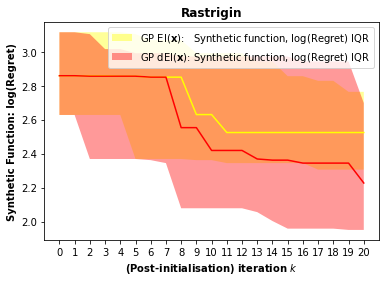

In [163]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


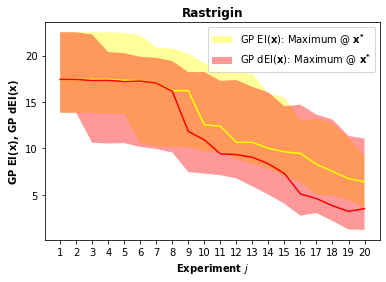

In [164]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approxAF, color = 'Yellow')
plt.plot(median_exactAF, color = 'Red')

xstar = np.arange(0, max_iter, step=1)
plt.fill_between(xstar, lower_approxAF, upper_approxAF, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$): Maximum @ $\mathbf{x^{*}}$')
plt.fill_between(xstar, lower_exactAF, upper_exactAF, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Maximum @ $\mathbf{x^{*}}$')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI($\mathbf{x}$), GP dEI($\mathbf{x}$)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show() #visualise!


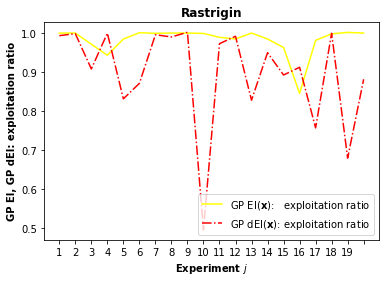

In [165]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(approx_ratio, color = 'Yellow', label='GP EI($\mathbf{x}$):   exploitation ratio')
plt.plot(exact_ratio, color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$): exploitation ratio')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment $\it{j}$' , weight = 'bold') # x-axis label
plt.ylabel('GP EI, GP dEI: exploitation ratio', weight = 'bold') # y-axis label
plt.legend(loc=4) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show()


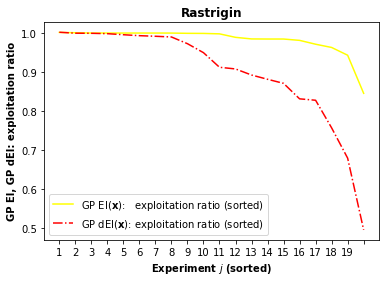

In [166]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(np.sort(approx_ratio)[::-1], color = 'Yellow', label='GP EI($\mathbf{x}$):   exploitation ratio (sorted)')
plt.plot(np.sort(exact_ratio)[::-1], color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$): exploitation ratio (sorted)')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment $\it{j}$ (sorted)' , weight = 'bold') # x-axis label
plt.ylabel('GP EI, GP dEI: exploitation ratio', weight = 'bold') # y-axis label
plt.legend(loc=3) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show()


In [167]:
np.sum((approx_1.start_points_arr - exact_1.start_points_arr)**2)


0.0

In [168]:
approx_mean_test, approx_var_test = surrogate_approx_1.predict(approx_1.start_points_arr,return_std=True)
approx_std_test = np.sqrt(approx_var_test + eps)
approx_mean_test, approx_std_test


(array([-16.37441914, -15.24636057, -12.00549532, -10.11767087,
         -9.49976565, -15.01248232, -16.93839183, -18.40463502,
        -17.54500693, -13.45191809, -18.45133145, -14.88336408,
         -9.86131578, -17.27544503, -11.71238431, -17.81749846,
        -18.11170353, -12.75286478, -11.21554167, -10.19772526]),
 array([1.94216508, 1.82928429, 1.74784524, 1.80058637, 1.96756604,
        1.90467506, 1.75797628, 1.78015309, 1.90665256, 1.90357346,
        1.79284209, 1.81071922, 1.75472058, 1.92079816, 1.81396511,
        1.74765832, 1.74936929, 1.87608554, 1.92615778, 1.98383148]))

In [169]:
exact_mean_test, exact_var_test = surrogate_exact_1.predict(exact_1.start_points_arr,return_std=True)
exact_std_test = np.sqrt(exact_var_test + eps)
np.round(exact_mean_test, 3), np.round(exact_std_test, 3)


(array([-26.457, -20.338, -22.388, -19.64 , -19.099, -19.206, -21.283,
        -13.64 , -23.609, -17.38 , -18.588, -12.813, -19.171, -13.582,
        -26.422, -23.111, -19.748, -24.987, -19.998, -17.392]),
 array([1.846, 1.88 , 1.842, 1.769, 1.872, 1.89 , 1.865, 1.937, 1.868,
        1.946, 1.768, 1.834, 1.855, 1.951, 1.751, 1.821, 1.743, 1.787,
        1.888, 1.876]))

In [170]:
-np.min(approx_1.f_best)

6.576722480473276

In [171]:
-np.min(exact_1.f_best)

13.274024995343561